In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors as mcolors
from matplotlib.colors import rgb2hex
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import datetime
import time
import numpy as np
import scipy as sp
from scipy import stats
import scipy.optimize as optimize
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from collections import Counter
import seaborn as sns; sns.set()
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

import plotly.express as px
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D

import itertools

from pyecharts.charts import Map, Geo
from pyecharts.faker import Faker
from pyecharts import options as opts
from pyecharts.globals import ChartType, SymbolType
from snapshot_selenium import snapshot
from pyecharts.render import make_snapshot
from __future__ import unicode_literals
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_NOTEBOOK
from pyecharts.commons.utils import JsCode

import import_ipynb
from utils_common import *

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from adjustText import adjust_text

importing Jupyter notebook from utils_common.ipynb


In [40]:
# Compress warnings: everyone will be tired of warnings (pretend that they do not exist...)
import warnings
warnings.filterwarnings("ignore", message="This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.")
warnings.filterwarnings("ignore", message="FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.")
warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:
_Data_PATH_ = './data/'
_Data_PATH_XX_ = './data/parameters_xx/'
_Data_PATH_MXX_ = './data/parameters_mxx/' # m stands for mobility
_Data_PATH_SP_ = './data/samples/' # samples of R

_Figure_PATH_ = './figures/'

_City_PATH_ = './data/data_DXY_city_all.csv'
_Province_PATH_ = './data/data_DXY_province_all.csv'
_Province_Domestic_PATH_ = './data/data_DXY_province_all_domestic.csv'
_City_MPATH_ = './data/data_bdqx_if_city.csv'
_Province_MPATH_ = './data/data_bdqx_if_province.csv'

In [4]:
# load internal flow index
def load_if_raw():
    raw_city = pd.read_csv(_City_MPATH_)
    raw_province = pd.read_csv(_Province_MPATH_) 
    raw_city['update_date'] = pd.to_datetime(raw_city['update_date'])
    raw_city['update_date'] = raw_city['update_date'].dt.date 
    raw_province['update_date'] = pd.to_datetime(raw_province['update_date'])
    raw_province['update_date'] = raw_province['update_date'].dt.date
    return raw_city, raw_province

In [5]:
# load parameters and estimation for every province # WITH MOBILITY
def load_ind_simulation_raw_mxxr(repetition):
    _Data_PATH_MXXR_ = './data/parameters_mxxr_' + str(repetition) + '/'
    df_parameters_list = []
    df_estimation_list = []
    for name in names_province:
        df_parameters_single = pd.read_csv(_Data_PATH_MXXR_ + name + '_mparameters.csv')
        df_estimation_single = pd.read_csv(_Data_PATH_MXXR_ + name + '_mestimation.csv')
        df_parameters_list.append(df_parameters_single)
        df_estimation_list.append(df_estimation_single)
    return df_parameters_list, df_estimation_list

In [6]:
# Calcuate the standard errors of parameters wo/ migration (from script: utils_parameters)
# reference: Dueling biological and social contagions, Feng Fu
# a linear approximation through estimation of the Jacobian matrix: 
# cov = sigma^2(F'F)^(-1)
# the unbiased estimation of sigma^2 obtained from the residuals of the parameter estimation:
# sigma = error/sqrt(number of observations - number of free parameters)
def SDE_xx(df_parameters_list, province_index, T = 21, TT = 6, TI = 3, ti = 7, figure = False):
    
    df_parameters = df_parameters_list[province_index].copy() # the parameters
    df_estimation = df_estimation_list[province_index].copy() # the estimation
    
    timespan = df_estimation.shape[0] # national timespan
    timespan_local = timespan - df_estimation['real'].isnull().sum() # provincial timespan
    
    e = np.linalg.norm(df_estimation.tail(timespan_local).residual) # Euclidean Norm of the residual
    k = df_parameters.shape[0] - 2 # number of free parameters (exclude N and S)
    sigma_e = e/np.sqrt(timespan_local - k) # sigma
    
    ps_old = dict(zip(df_parameters.parameter, df_parameters.value))
    para_list = df_parameters.parameter.tolist() 
    para_list.remove('N')
    para_list.remove('S_0')
    
    list_front = np.repeat(range(int(np.ceil(T/TI))), TI).tolist()
    list_end = np.repeat(range(int(np.ceil((timespan - T)/ti))), ti).tolist()
    list_end = [item + max(list_front) + 1 for item in list_end]
    index_list = list_front + list_end
    index_list = index_list[:timespan] # index list for beta
    list_front_gs = [0]*TT + [1]*TT
    list_end_gs = [2]*(timespan - TT - TT)
    index_list_gs = list_front_gs + list_end_gs # index list for gamma and sigma
    
    ts = range(0, timespan)
    nbeta = int(T/TI + np.ceil((timespan - T)/ti)) # number of beta's
    
    # Least-square fitting
    def SEIR_equations(states, t, ps):
        """Receptor synthesis-internalization model."""
        # integrate.ode may generate t values outside the data range
        beta_index = index_list[min(round(t), timespan - 1)]
        gs_index = index_list_gs[min(round(t), timespan - 1)]
        beta = ps['beta_' + str(beta_index)]
        gamma = ps['gamma_' + str(gs_index)]
        sigma = ps['sigma_' + str(gs_index)]
        N = ps['N']
        S, E, I, R = states
        return [-beta*S*I/N, beta*S*I/N - sigma*E, sigma*E - gamma*I, gamma*I]
    
    def SEIR(states_0, ts, ps):
        """
        Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
        """
        states = odeint(SEIR_equations, states_0, ts, args=(ps,))
        return states
    
    # Calculate the estimation
    def estimation(ps, ts):
        states_0 = ps['N'] - ps['E_0'] - ps['I_0'] - ps['R_0'], ps['E_0'], ps['I_0'], ps['R_0']
        model = SEIR(states_0, ts, ps)
        est = model[:,3]
        return est
    
    J = np.zeros((timespan_local, k)) # Jacobian matrix
    
    for j in range(0, k):
        para = para_list[j]
        para_value_old = ps_old[para]
        if para_value_old >= 1e-5:
            para_value_change = 1e-2*para_value_old # difference = one percent
        else: # in case the value of a parameter is zero
            para_value_change = 1e-7 
        ps_new = dict(zip(df_parameters.parameter, df_parameters.value))
        ps_new[para] = para_value_old + para_value_change
        final = estimation(ps_new, ts)
        J[:,j] = (df_estimation.tail(timespan_local).estimation - final[-timespan_local:])/para_value_change
        
        palette = plt.get_cmap('magma')
        if figure:
            fig = plt.figure(figsize = (10,5))
            plt.plot(ts, df_estimation.estimation, '-', linewidth = 2, color = palette(0.6))
            plt.plot(ts, final, '--', linewidth = 2, color = palette(0.8))
            plt.title(para)
            plt.xlabel('Date')
            plt.ylabel('Number of people')
        
    H = np.transpose(J).dot(J)
    H_inverse = np.linalg.inv(H)
    df_parameters["sde"] = np.nan
    df_parameters["lower_bound"] = np.nan
    df_parameters["upper_bound"] = np.nan
    
    for j in range(0, k):
        para = para_list[j]
        df_parameters.loc[df_parameters.parameter == para, 'sde'] = sigma_e*np.sqrt(H_inverse[j][j]/ps_old['N'])
    # calculate the lower bound and upper bound of every parameter (99.9% confidence interval)
    # lower bound is non-negative
    # !!! ignore nan !!!
    df_parameters["lower_bound"] = df_parameters.apply(lambda row: np.nanmax([row.value - row.sde*stats.t.ppf(1-0.0005, timespan_local - k), 0]), axis = 1)
    df_parameters["upper_bound"] = df_parameters.apply(lambda row: row.value + row.sde*stats.t.ppf(1-0.0005, timespan_local - k), axis = 1)
    ###### the value of beta cannot be less than 0.01
    ###### the value of beta cannot exceed 1
    for j in range(max(index_list) + 1):
        df_parameters.loc[df_parameters.parameter == 'beta_' + str(int(j)), 'lower_bound'] = np.nanmax([df_parameters.loc[df_parameters.parameter == 'beta_' + str(int(j)), 'lower_bound'].tolist()[0], 0.01])
        df_parameters.loc[df_parameters.parameter == 'beta_' + str(int(j)), 'upper_bound'] = np.nanmin([df_parameters.loc[df_parameters.parameter == 'beta_' + str(int(j)), 'upper_bound'].tolist()[0], 1])
    ###### the value of gamma and sigma cannot be less than 0.05
    ###### the value of gamma and sigma cannot exceed 0.5
    for j in range(max(index_list_gs) + 1):
        df_parameters.loc[df_parameters.parameter == 'gamma_' + str(int(j)), 'lower_bound'] = np.nanmax([df_parameters.loc[df_parameters.parameter == 'gamma_' + str(int(j)), 'lower_bound'].tolist()[0], 0.05])
        df_parameters.loc[df_parameters.parameter == 'sigma_' + str(int(j)), 'lower_bound'] = np.nanmax([df_parameters.loc[df_parameters.parameter == 'sigma_' + str(int(j)), 'lower_bound'].tolist()[0], 0.05])
        
        df_parameters.loc[df_parameters.parameter == 'gamma_' + str(int(j)), 'upper_bound'] = np.nanmin([df_parameters.loc[df_parameters.parameter == 'gamma_' + str(int(j)), 'upper_bound'].tolist()[0], 0.5])
        df_parameters.loc[df_parameters.parameter == 'sigma_' + str(int(j)), 'upper_bound'] = np.nanmin([df_parameters.loc[df_parameters.parameter == 'sigma_' + str(int(j)), 'upper_bound'].tolist()[0], 0.5])
    return df_parameters

In [7]:
# Calcuate the standard errors of parameters w/ migration (from script: utils_mparameters)
def SDE_mxx(df_mparameters_list, mindex_list, T = 21, TT = 6, TI = 3, ti = 7, 
            subject = 'bound', scale = True, limit = True):
    
    m = len(names_province)
    timespan = df_mestimation_list[0].shape[0] 
    k = (df_mparameters_list[0].shape[0] - 2)*m
    timespan_local_list = []
    ps_old = {'theta': 1e5}
    para_list = [] # names of independent parameters
    e = 0
    
    list_front = np.repeat(range(int(np.ceil(T/TI))), TI).tolist()
    list_end = np.repeat(range(int(np.ceil((timespan - T)/ti))), ti).tolist()
    list_end = [item + max(list_front) + 1 for item in list_end]
    index_list = list_front + list_end
    index_list = index_list[:timespan] # index list for beta
    list_front_gs = [0]*TT + [1]*TT
    list_end_gs = [2]*(timespan - TT - TT)
    index_list_gs = list_front_gs + list_end_gs # index list for gamma and sigma
    
    for i, province in enumerate(names_province):
        df_mparameters = df_mparameters_list[i].copy() 
        df_mestimation = df_mestimation_list[i].copy() 
        timespan_local = timespan - df_mestimation['real'].isnull().sum() 
        timespan_local_list.append(timespan_local)
        ps_name = ['N_' + str(i), 'E_' + str(i) + '_0', 'I_' + str(i) + '_0', 'R_' + str(i) + '_0', 'S_' + str(i) + '_0']
        ps_name += ['beta_' + str(i) + '_' + str(int(j)) for j in range(max(index_list) + 1)]
        ps_name += ['gamma_' + str(i) + '_' + str(int(j)) for j in range(max(index_list_gs) + 1)]
        ps_name += ['sigma_' + str(i) + '_' + str(int(j)) for j in range(max(index_list_gs) + 1)]
        ps_old.update(dict(zip(ps_name, df_mparameters.value)))
        para_list += ps_name
        para_list.remove('N_' + str(i))
        para_list.remove('S_' + str(i) + '_0')
        e += np.linalg.norm(df_mestimation.tail(timespan_local).mestimation - df_mestimation.tail(timespan_local).real)**2
          
    e = np.sqrt(e)
    dof = np.sum(timespan_local_list) - k
    sigma_e = e/np.sqrt(dof)
    ts = range(0, timespan)
    
    
    # Least-square fitting
    # SEIR model with migration
    def SEIR_equations(states, t, ps):
        """Receptor synthesis-internalization model."""
        states = states.reshape((m, 4)) # S_i, E_i, I_i, R_i, S_j, E_j, I_j, R_j
        S, E, I, R = states[:,0], states[:,1], states[:,2], states[:,3]
        N = S + E + I + R
        RHS = [] # right hand side
        theta = ps['theta']
        # integrate.ode may generate t values outside the data range
        mindex = mindex_list[min(round(t), timespan - 1)] # migration matrix: m_ij from i to j
        for i, name in enumerate(names_province):
            # integrate.ode may generate t values outside the data range
            beta_index = index_list[min(round(t), timespan - 1)]
            gs_index = index_list_gs[min(round(t), timespan - 1)]
            beta = ps['beta_' + str(i) + '_' + str(beta_index)]
            gamma = ps['gamma_' + str(i) + '_' + str(gs_index)]
            sigma = ps['sigma_' + str(i) + '_' + str(gs_index)]
            dS = -beta*S[i]*I[i]/N[i] - theta/N[i]*np.sum(mindex[i, :])*S[i] + theta*np.sum(np.multiply(np.divide(mindex[:,i], N), S))
            dE = beta*S[i]*I[i]/N[i] - sigma*E[i] - theta/N[i]*np.sum(mindex[i, :])*E[i] + theta*np.sum(np.multiply(np.divide(mindex[:,i], N), E))
            dI = sigma*E[i] - gamma*I[i]
            dR = gamma*I[i]
            RHS += [dS, dE, dI, dR]
        return RHS
    
    def SEIR(states_0, ts, ps):
        """
        Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
        """
        states = odeint(SEIR_equations, states_0, ts, args = (ps,))
        return states
    
    # Calculate the estimation
    def estimation(ps, ts):
        states_0 = []
        for i, name in enumerate(names_province):
            states_single_0 = ps['S_' + str(i) + '_0'], ps['E_' + str(i) + '_0'], ps['I_' + str(i) + '_0'], ps['R_' + str(i) + '_0']
            states_0 += states_single_0
        model = SEIR(states_0, ts, ps)
        est = np.zeros((timespan, m))
        for i, name in enumerate(names_province):
            est_single = model[:,(3 + i*4)]
            est[:, i] = est_single
        return est
    
    final_old = estimation(ps_old, ts)
    
    J = np.zeros((np.sum(timespan_local_list), k)) # Jacobian matrix
    
    
    for j in range(0, k):
        para = para_list[j]
        para_value_old = ps_old[para]
        para_value_change = (lambda x: 1e-2*x if x >= 1e-2 else 1e-4)(para_value_old) # one percent
        ps_new = ps_old.copy()
        ps_new[para] = para_value_old + para_value_change
        final = estimation(ps_new, ts)
        
        temp = np.array([])
        for i in range(0, m):
            temp = np.append(temp, final_old[:, i][-timespan_local_list[i]:] - final[:, i][-timespan_local_list[i]:])
            
        J[:,j] = temp/para_value_change
           
    H = np.transpose(J).dot(J)
    H_inverse = np.linalg.inv(H)
    
    N_list = [df_mparameters_list[i]['value'][0] for i in range(0, m)]
    if scale == True:
        cov = sigma_e**2*H_inverse/(np.sum(N_list)*ps_old['theta']) # 🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑
    else:
        cov = sigma_e**2*H_inverse
        
    print(np.sum(timespan_local_list), k, np.sum(N_list))
        
    np.savetxt(_Data_PATH_ + "mcov.csv", cov, delimiter = ",")
        
    df_mparameters_all = pd.DataFrame(list(ps_old.items()),columns = ['parameter','value']) 
    df_mparameters_all["sde"] = np.nan
    df_mparameters_all["lower_bound"] = np.nan
    df_mparameters_all["upper_bound"] = np.nan
    
    for j in range(0, k):
        para = para_list[j]
        df_mparameters_all.loc[df_mparameters_all.parameter == para, 'sde'] = sigma_e*np.sqrt(H_inverse[j][j]/(np.sum(N_list)*ps_old['theta']))
    # calculate the lower bound and upper bound of every parameter (99.9% confidence interval)
    # lower bound is non-negative
    # !!! ignore nan !!!
    df_mparameters_all["lower_bound"] = df_mparameters_all.apply(lambda row: np.nanmax([row.value - row.sde*stats.t.ppf(1-0.0005, dof), 0]), axis = 1)
    df_mparameters_all["upper_bound"] = df_mparameters_all.apply(lambda row: row.value + row.sde*stats.t.ppf(1-0.0005, dof), axis = 1)
    ###### the values of E_0, I_0, and R_0 cannot exceed 500, 200, and 100
    ###### the value of beta cannot be less than 0.01
    ###### the value of beta cannot exceed 1
    if limit == True:
        for i in range(0, m):
            df_mparameters_all.loc[df_mparameters_all.parameter == 'E_' + str(i) + '_0', 'upper_bound'] = np.nanmin([df_mparameters_all.loc[df_mparameters_all.parameter == 'E_' + str(i) + '_0', 'upper_bound'].tolist()[0], 500])
            df_mparameters_all.loc[df_mparameters_all.parameter == 'I_' + str(i) + '_0', 'upper_bound'] = np.nanmin([df_mparameters_all.loc[df_mparameters_all.parameter == 'I_' + str(i) + '_0', 'upper_bound'].tolist()[0], 200])
            df_mparameters_all.loc[df_mparameters_all.parameter == 'R_' + str(i) + '_0', 'upper_bound'] = np.nanmin([df_mparameters_all.loc[df_mparameters_all.parameter == 'R_' + str(i) + '_0', 'upper_bound'].tolist()[0], 100])
            for j in range(max(index_list) + 1):
                df_mparameters_all.loc[df_mparameters_all.parameter == 'beta_' + str(i) + '_' + str(int(j)), 'lower_bound'] = np.nanmax([df_mparameters_all.loc[df_mparameters_all.parameter == 'beta_' + str(i) + '_' + str(int(j)), 'lower_bound'].tolist()[0], 0.01])
                df_mparameters_all.loc[df_mparameters_all.parameter == 'beta_' + str(i) + '_' + str(int(j)), 'upper_bound'] = np.nanmin([df_mparameters_all.loc[df_mparameters_all.parameter == 'beta_' + str(i) + '_' + str(int(j)), 'upper_bound'].tolist()[0], 1])
            ###### the value of gamma and sigma cannot be less than 0.05
            ###### the value of gamma and sigma cannot exceed 0.5
            for j in range(max(index_list_gs) + 1):
                df_mparameters_all.loc[df_mparameters_all.parameter == 'gamma_' + str(i) + '_' + str(int(j)), 'lower_bound'] = np.nanmax([df_mparameters_all.loc[df_mparameters_all.parameter == 'gamma_' + str(i) + '_' + str(int(j)), 'lower_bound'].tolist()[0], 0.05])
                df_mparameters_all.loc[df_mparameters_all.parameter == 'sigma_' + str(i) + '_' + str(int(j)), 'lower_bound'] = np.nanmax([df_mparameters_all.loc[df_mparameters_all.parameter == 'sigma_' + str(i) + '_' + str(int(j)), 'lower_bound'].tolist()[0], 0.05])

                df_mparameters_all.loc[df_mparameters_all.parameter == 'gamma_' + str(i) + '_' + str(int(j)), 'upper_bound'] = np.nanmin([df_mparameters_all.loc[df_mparameters_all.parameter == 'gamma_' + str(i) + '_' + str(int(j)), 'upper_bound'].tolist()[0], 0.5])
                df_mparameters_all.loc[df_mparameters_all.parameter == 'sigma_' + str(i) + '_' + str(int(j)), 'upper_bound'] = np.nanmin([df_mparameters_all.loc[df_mparameters_all.parameter == 'sigma_' + str(i) + '_' + str(int(j)), 'upper_bound'].tolist()[0], 0.5])

        #df_mparameters_all.loc[df_mparameters_all.parameter == 'theta', 'lower_bound'] = ps_old['theta']
        #df_mparameters_all.loc[df_mparameters_all.parameter == 'theta', 'upper_bound'] = ps_old['theta']
        
        #df_mparameters_all.loc[df_mparameters_all.parameter == 'N_' + str(i), 'lower_bound'] = ps_old['N_' + str(i)]
        #df_mparameters_all.loc[df_mparameters_all.parameter == 'N_' + str(i), 'upper_bound'] = ps_old['N_' + str(i)]
    
    
    df_mparameters_all.to_csv(_Data_PATH_ + 'mparameters_all.csv', index = False)
    
    return cov, df_mparameters_all

In [8]:
# get a sample set of the parameters w/ migration
def SDE_mxx_sample(df_mparameters_all, cov, size = 1, limit = True): # limit: upper bounds
    
    para_list = df_mparameters_all['parameter'].tolist()
    para_list = [p for p in para_list if ('theta' not in p) & ('N' not in p) & ('S' not in p)]
    
    mean = df_mparameters_all[df_mparameters_all.parameter.isin(para_list)].value.tolist()
    
    df_mparameters_sample = df_mparameters_all.copy()
    
    for flag in range(0, size):
        if flag == 0:
            sample = mean.copy()
        else:
            sample = np.random.multivariate_normal(mean, cov, 1)[0]
        for k, ps in enumerate(para_list):
            if 'beta' in ps:
                sample[k] = max(sample[k], 0) # 0.01
                if limit == True:
                    sample[k] = max(sample[k], 0.01) 
                    sample[k] = min(sample[k], 1)
            elif ('gamma' in ps) or ('sigma' in ps):
                sample[k] = max(sample[k], 0) # 0.05
                if limit == True:
                    sample[k] = max(sample[k], 0.05)
                    sample[k] = min(sample[k], 0.5)
            else:
                sample[k] = max(sample[k], 0) # 0
                if limit == True:
                    max_dict = {'E': 500, 'I': 200, 'R': 100}
                    sample[k] = min(sample[k], max_dict[ps[0]])
            
        def assignment(name):
            if name in para_list:
                return sample[para_list.index(name)]
            elif ('theta' in name) or ('N' in name):
                return df_mparameters_all[df_mparameters_all['parameter'] == name]['value'].tolist()[0]
            elif 'S' in name:
                N_temp = df_mparameters_all[df_mparameters_all['parameter'] == 'N_' + name[2:-2]]['value'].tolist()[0]
                return N_temp - sample[para_list.index('E_' + name[2:])] - sample[para_list.index('I_' + name[2:])] - sample[para_list.index('R_' + name[2:])]
            else:
                return np.nan
                
        df_mparameters_sample['sample_' + str(flag)] = df_mparameters_sample['parameter'].apply(assignment)
            
    return df_mparameters_sample

### Covariance, lower bounds, and upper bounds
🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑🍑

In [9]:
def ode_state(df, df_mparameters_state, update_date_tr, mindex_list, T = 21, TT = 6, TI = 3, ti = 7, sample = -1):
    start_time = time.time() 
    m = len(names_province)
    df = df[df.update_date <= update_date_tr] 
    timespan = (max(df.update_date) - min(df.update_date)).days + 1
    ################## for beta, generate an index list
    list_front = np.repeat(range(int(np.ceil(T/TI))), TI).tolist()
    list_end = np.repeat(range(int(np.ceil((timespan - T)/ti))), ti).tolist()
    list_end = [item + max(list_front) + 1 for item in list_end]
    index_list = list_front + list_end
    index_list = index_list[:timespan] 
    ################## 
    ################## for sigma and gamma, generate an index list
    list_front_gs = [0]*TT + [1]*TT
    list_end_gs = [2]*(timespan - TT - TT)
    index_list_gs = list_front_gs + list_end_gs
    ################## 
    df_single_list = [] # list of dataframes 
    ts_local_list = [] # list of provincial timespans
    data = np.zeros((timespan, m)) # cumulative numbers of confirmed cases
    
    for i, name in enumerate(names_province):
        df_single = df[df.province_name_en == name]
        timespan_local = (max(df_single.update_date) - min(df_single.update_date)).days + 1
        df_single_list.append(df_single)
        ts_local_list.append(timespan_local)
        data_single = np.array(df_single.cum_confirmed)
        data_single = np.concatenate(([None]*(timespan - timespan_local), data_single), axis=0)
        data[:,i] = data_single
    
    # Least-square fitting
    # SEIR model with migration
    def SEIR_equations(states, t, ps):
        """Receptor synthesis-internalization model."""
        states = states.reshape((m, 4)) # S_i, E_i, I_i, R_i, S_j, E_j, I_j, R_j
        S, E, I, R = states[:,0], states[:,1], states[:,2], states[:,3]
        N = S + E + I + R
        RHS = [] # right hand side
        theta = ps['theta']
        # integrate.ode may generate t values outside the data range
        mindex = mindex_list[min(round(t), timespan - 1)] # migration matrix: m_ij from i to j
        for i, name in enumerate(names_province):
            # integrate.ode may generate t values outside the data range
            beta_index = index_list[min(round(t), timespan - 1)]
            gs_index = index_list_gs[min(round(t), timespan - 1)]
            beta = ps['beta_' + str(i) + '_' + str(beta_index)]
            gamma = ps['gamma_' + str(i) + '_' + str(gs_index)]
            sigma = ps['sigma_' + str(i) + '_' + str(gs_index)]
            
            dS = -beta*S[i]*I[i]/N[i] - theta/N[i]*np.sum(mindex[i, :])*S[i] + theta*np.sum(np.multiply(np.divide(mindex[:,i], N), S))
            dE = beta*S[i]*I[i]/N[i] - sigma*E[i] - theta/N[i]*np.sum(mindex[i, :])*E[i] + theta*np.sum(np.multiply(np.divide(mindex[:,i], N), E))
            dI = sigma*E[i] - gamma*I[i]
            dR = gamma*I[i]
            RHS += [dS, dE, dI, dR]
        return RHS
    
    def SEIR(states_0, ts, ps):
        """
        Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
        """
        states = odeint(SEIR_equations, states_0, ts, args = (ps,))
        return states
    
    # Calculate the estimation
    def estimation(ps, ts):
        states_0 = []
        for i, name in enumerate(names_province):
            states_single_0 = ps['S_' + str(i) + '_0'], ps['E_' + str(i) + '_0'], ps['I_' + str(i) + '_0'], ps['R_' + str(i) + '_0']
            states_0 += states_single_0
        model = SEIR(states_0, ts, ps)
        est_S, est_E, est_I, est_R = np.zeros((timespan, m)), np.zeros((timespan, m)), np.zeros((timespan, m)), np.zeros((timespan, m))
        for i, name in enumerate(names_province):
            est_single_S = model[:,(0 + i*4)]; est_S[:, i] = est_single_S
            est_single_E = model[:,(1 + i*4)]; est_E[:, i] = est_single_E
            est_single_I = model[:,(2 + i*4)]; est_I[:, i] = est_single_I
            est_single_R = model[:,(3 + i*4)]; est_R[:, i] = est_single_R
        return est_S, est_E, est_I, est_R
    
    ts = range(0, timespan)
    if sample == -1:
        ps = pd.Series(df_mparameters_state['value'].values, index = df_mparameters_state['parameter']).to_dict()
    else:
        ps = pd.Series(df_mparameters_state['sample_' + str(sample)].values, index = df_mparameters_state['parameter']).to_dict()
    
    est_S, est_E, est_I, est_R = estimation(ps, ts)
    
    return est_S, est_E, est_I, est_R

In [10]:
def ode_state_bound(df, df_mparameters_sample, update_date_tr, mindex_list, error = 0.025):
    
    start = time.time()

    sample_size = df_mparameters_sample.shape[1] - 5
    R_list = []
    for i in range(0, sample_size):
        _, _, _, est_R = ode_state(df = df, df_mparameters_state = df_mparameters_sample, 
                                   update_date_tr = update_date_tr, mindex_list = mindex_list, 
                                   T = 21, TT = 6, TI = 3, ti = 7, sample = i)
        R_list.append(est_R) 
        if i == 0:
            est_R_lower = np.zeros(est_R.shape)
            est_R_upper = np.zeros(est_R.shape)
    
    for i in range(0, est_R_lower.shape[1]):
        R_array = [item[:, i] for item in R_list]
        R_array = np.stack(R_array, axis = 1)
        est_R_lower[:, i] = np.quantile(R_array, error, axis = 1)
        est_R_upper[:, i] = np.quantile(R_array, 1 - error, axis = 1)
        np.savetxt(_Data_PATH_SP_ + names_province[i] + "_msample.csv", R_array, delimiter = ",")
        
    end = time.time()
    duration = round((end - start)/60)
    print('duration: ' + str(duration) + ' minutes')
    
    return est_R_lower, est_R_upper

In [11]:
# plot the correlation between mobility and transmission of the disease
# job: 
#### 1 onset
#### At day ? the nth (recovered) patient appeared for every province (Hubei is not included)
#### 1.1. oneset 
# x-axis: cumulative mobility index (from start_date to end_date)
# y-axis: number of infected poeple, date the nth patient appeared
##### 1.2. oneset single
# x-axis: cumulative mobility index (from start_date to end_date)
# y-axis: date the nth patient appeared
# point size: number of infected poeple
#### 2 incubation
#### compare the value of E_0 (prior estimation without mobility VS posterior estimation with mobility)
#### find those provinces got most of the asymptomatic carriers from Hubei province
#### 2.1 diff
#### 2.2 ratio
#### 2.3 value
#### 3 scatter
#### 4 heatmap
#### 5 circle
def correlation(nth, top, start_date, end_date, fs, 
                pieces, vr_upper, job = 'onset', diff = 10, ratio = 80, value = 0):
    # At day ? the nth (recovered) patient appeared for every province (Hubei is not included)
    onset = [(name, df_mestimation_list[i].index[round(df_mestimation_list[i].estimation) >= nth].tolist()[0] + 1) for i, name in enumerate(names_province_cn)]
    onset = dict(sorted(onset, key = lambda tup: tup[1])) # sorting
    if ('diff' not in job) & ('ratio' not in job) & ('value' not in job):
        data_single = data_province_domestic[data_province_domestic.update_date == end_date]
        #data_single = data_province_domestic[data_province_domestic.update_date == datetime.date(int(2020),int(3),int(10))]
        data_single = data_single.sort_values(by = 'cum_confirmed', ascending = False)
        data_single = data_single.reset_index(drop = True)
        # for the scatter plot or the heatmap 
        # the order here is different from the global list names_province (imported from utils.common)
        provinces = data_single.province_name
        provinces = [pyecharts_province_dict[temp] for temp in provinces] # pyecharts has its own naming for provinces
        values = data_single.cum_confirmed
    # get the cumulative mobility index from start_date to end_date
    data_m = data_network_P2P[(data_network_P2P.update_date >= start_date) & (data_network_P2P.update_date <= end_date)]
    data_m = data_m.drop(['update_date'], axis = 1)
    data_m = data_m.groupby(['source','target'])['value'].sum().reset_index() # adding up
    data_m_single = data_m[data_m.source == '湖北省'].sort_values(by = 'value') # from Hubei province to other province
    data_m_single_top = data_m_single.tail(top) # only keep the top ones
    # for the mobility curves (from Hubei to other provinces)
    sources = data_m_single_top.source.tolist()
    targets = data_m_single_top.target.tolist()
    
    # compare the value of E_0 (prior estimation without mobility VS posterior estimation with mobility)
    # find those provinces got most of the asymptomatic carriers from Hubei province
    if 'diff' in job:
        # prior - posterior > ?
        diff_E_0 = [round(df_mparameters_list[i][df_mparameters_list[i]['parameter'] == 'E_0']['value'].tolist()[0] - 
                         df[df['parameter'] == 'E_0']['value'].tolist()[0]) for i, df in enumerate(df_parameters_list)]
        E_0_sub = [item for item in diff_E_0 if item <= - diff]
        provinces_sub = [item for i, item in enumerate(names_province_cn) if diff_E_0[i] <= - diff]
        provinces_sub = [pyecharts_province_dict[temp] for temp in provinces_sub]
        
    elif 'ratio' in job:
        # ratio < ?%
        ratio_E_0 = [round(100*df_mparameters_list[i][df_mparameters_list[i]['parameter'] == 'E_0']['value'].tolist()[0]/
                             df[df['parameter'] == 'E_0']['value'].tolist()[0], 2) for i, df in enumerate(df_parameters_list)]
        E_0_sub = [item for item in ratio_E_0 if item <= ratio]
        provinces_sub = [item for i, item in enumerate(names_province_cn) if ratio_E_0[i] <= ratio]
        provinces_sub = [pyecharts_province_dict[temp] for temp in provinces_sub]
        
    elif 'value' in job:
        E_0 = [round(df_m[df_m['parameter'] == 'E_0']['value'].tolist()[0]) for df_m in df_mparameters_list]
        E_0_sub = [item for item in E_0 if item >= value]
        provinces_sub = [item for i, item in enumerate(names_province_cn) if E_0[i] >= value]
        provinces_sub = [pyecharts_province_dict[temp] for temp in names_province_cn]
    
    if "circle" in job:
        # add more edges
        targets_current = []
        while set(targets_current)!= set(targets):
            targets_diff = [temp for temp in targets if temp not in targets_current]
            targets_current = targets.copy()
            for target in targets_diff:
                data_m_ssingle = data_m[data_m.source == target].sort_values(by = 'value')
                sources += [target]*top
                targets += data_m_ssingle.tail(top).target.tolist()
                
    sources = [pyecharts_province_dict[temp] for temp in sources]
    targets = [pyecharts_province_dict[temp] for temp in targets]
    # add new columns to the dataframe
    if ('diff' not in job) & ('ratio' not in job) & ('value' not in job):
        data_m_single['ranking'] = data_m_single.apply(lambda row: data_single.index[data_single['province_name'] == row.target].tolist()[0] + 1, axis = 1) # by number of confirmed cases
        data_m_single['cum_confirmed'] = data_m_single.apply(lambda row: data_single[data_single['province_name'] == row.target]['cum_confirmed'].tolist()[0], axis = 1) 
    data_m_single['onset_date'] = data_m_single.apply(lambda row: timedelta(days = onset[row.target] - 1) + min(data_province_domestic['update_date']), axis = 1) # date
    data_m_single['onset'] = data_m_single.apply(lambda row: onset[row.target], axis = 1) # number
    data_m_single = data_m_single.reset_index(drop = True)
    data_m_single = add_en_location(data_m_single, tag = 'network')
    # Javascript label for pyecharts map
    ln = """
    function(params) {
        if(params.name == '湖北')
            return 'Hubei';
        if(params.name == '广东')
            return 'Guangdong';
        if(params.name == '河南')
            return 'Henan';
        if(params.name == '浙江')
            return 'Zhejiang';
        if(params.name == '湖南')
            return 'Hunan';
        return '';
    }
    """
    adding = start_date.strftime("%d %B, %Y") + ' - ' + end_date.strftime("%d %B, %Y")
    # two panels
    if job == 'onset':
        sns.set_style("whitegrid")
        
        fig = plt.figure(figsize = (10,8))
        ax1 = fig.add_subplot(211)
        palette = ['#d8b9c3', '#827397', '#4d4c7d', '#363062']
        
        colors = list(itertools.chain.from_iterable(itertools.repeat(x, 8) for x in palette)) 
        colors = colors[:data_m_single.shape[0]]
        ax1.scatter(data_m_single.value, data_m_single.cum_confirmed, s = 120, c = colors, alpha = 0.8, 
                    label = 'number of patients')
        #sns.regplot(data_m_single.value, data_m_single.cum_confirmed, # linear regression with error bar
                 #color = palette[2], scatter_kws={"alpha":0.6,"s":0}, label = None)
        ax1.set_xlabel('')
        ax1.set_ylabel('Number', fontsize = fs - 2)
        ax1.legend(loc = 'upper left', fancybox = True, fontsize = fs - 4)
        ax2 = fig.add_subplot(212)
        palette = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
        colors = list(itertools.chain.from_iterable(itertools.repeat(x, 8) for x in palette)) 
        colors = colors[:data_m_single.shape[0]]
        ax2.scatter(data_m_single.value, data_m_single.onset_date, s = 120, c = colors, alpha = 0.8, 
                    label = 'appearance of the ' + str(nth) + 'th patient')
        #sns.regplot(data_m_single.value, data_m_single.onset, 
                 #color = palette[2], scatter_kws={"alpha":0.6,"s":0}, label = None)
        
        ax2.set_xlabel('Cumulative mobility index from Hubei', fontsize = fs - 2)
        ax2.set_ylabel('Date', fontsize = fs - 2)
        ax2.set_ylim(min(data_m_single.onset_date) - timedelta(days = 2), max(data_m_single.onset_date) + timedelta(days = 2))
        ax2.yaxis.set_major_locator(mdates.AutoDateLocator())
        ax2.yaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax2.legend(loc = 'upper left', fancybox = True, fontsize = fs - 4)
        ax1.get_yaxis().set_label_coords(-0.075, 0.5)
        ax2.get_yaxis().set_label_coords(-0.075, 0.5)
        fig.suptitle('Correlation: mobility and infection', fontsize = fs, y = 1.01) 
        #fig.savefig(_Figure_PATH_ + 'China_correlation_' + end_date.strftime("%Y-%m-%d") + '.png', dpi = 400, bbox_inches='tight')
        return data_m_single, fig
    
    # only one panel
    elif job == 'onset single':
        
        sns.set_style("whitegrid")
        fig = plt.figure(figsize = (12, 10))
        ax = fig.add_subplot(111)
        palette = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
        colors = list(itertools.chain.from_iterable(itertools.repeat(x, 8) for x in palette)) 
        colors = colors[:data_m_single.shape[0]]
        # the size of the ith point is linearly related to the number of confirmed cases of the ith province
        ss = [200 + 800*(i-min(data_m_single.cum_confirmed))/(max(data_m_single.cum_confirmed)-min(data_m_single.cum_confirmed)) 
             for i in data_m_single.cum_confirmed.tolist()]
        # generate four intervals
        #r_list = np.linspace(min(data_m_single.cum_confirmed), max(data_m_single.cum_confirmed), 5)
        r_list = data_m_single['cum_confirmed'].quantile([0, 0.25, 0.5, 0.75, 1]).values.tolist()
        for i, r in enumerate(r_list[:-1]):
            indices = [k for k, temp in enumerate(data_m_single.cum_confirmed.tolist()) if (temp >= r) & (temp <= r_list[i+1])]
            s = [temp for k, temp in enumerate(ss) if k in indices]
            ax.scatter(data_m_single.onset_date[indices], data_m_single.value[indices],  s = s, c = palette[i], alpha = 0.8, 
                        label = str(int(r)) + r' $\leq n_{\mathrm{patient}}$ ' + 
                       (lambda x: r'$<$' if x < 3 else r'$\leq$')(i) + str(int(r_list[i+1])))
        for i, name in enumerate(data_m_single.target_en.tolist()):
            if name not in ['Beijing', 'Shanghai']:
                ax.annotate(name, (data_m_single.onset_date[i], data_m_single.value[i]), 
                                   fontsize = fs - 4)
            elif name in ['Beijing', 'Chongqing']:
                ax.annotate(name, (data_m_single.onset_date[i] - timedelta(days = 3), data_m_single.value[i]), 
                                   fontsize = fs - 4)
                days_dict = {'Beijing': 3, 'Chongqing': 3}
                ax.hlines(y = data_m_single.value[i] - 0.02, 
                          xmin = data_m_single.onset_date[i] - timedelta(days = days_dict[name]), 
                          xmax = data_m_single.onset_date[i], 
                          color = 'silver', linewidth = 2, alpha = 0.6, label = None)
            else:
                ax.annotate(name, (data_m_single.onset_date[i] + timedelta(days = 2), data_m_single.value[i]), 
                                   fontsize = fs - 4)
                days_dict = {'Shanghai': 4, 'Tianjin': 3}
                ax.hlines(y = data_m_single.value[i] - 0.02, 
                          xmin = data_m_single.onset_date[i], 
                          xmax = data_m_single.onset_date[i] + timedelta(days = days_dict[name]), 
                          color = 'silver', linewidth = 2, alpha = 0.6, label = None)
        ax.set_xlabel('Appearance of the ' + str(nth) + 'th patient', fontsize = fs - 2)
        ax.set_xlim(min(data_m_single.onset_date) - timedelta(days=2), max(data_m_single.onset_date) + timedelta(days=2))
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.set_yscale('log')
        ax.set_ylim(0.2, 30)
        ax.set_ylabel('Cumulative mobility index from Hubei', fontsize = fs - 2)
        ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 6)
        ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 6)
        
        #ax.set_title(adding, fontsize = fs - 4, y = 1.01) 
        plt.figtext(0.5, 1, adding, ha = "center", va = "top", fontsize = fs - 4)
        fig.suptitle('Correlation: mobility and infection', fontsize = fs, y = 1.045)
        ax.legend(loc = 'upper right', fancybox = True, fontsize = fs - 2)
        
        #fig.savefig(_Figure_PATH_ + 'figures_china/' + 'China_correlation_' + end_date.strftime("%Y-%m-%d") + '.png', dpi = 400, bbox_inches='tight')
        fig.savefig(_Figure_PATH_ + 'figures_china/' + 'China_corr_' + end_date.strftime("%m%d") + '.png', dpi = 400, bbox_inches='tight')
        return data_m_single, fig
    # scatter map
    elif 'scatter' in job:
        c = (
            Geo(init_opts = opts.InitOpts(width = '900px', height = '600px', bg_color = "#FFFFFF"),)
            .add_schema(maptype = "china", itemstyle_opts = opts.ItemStyleOpts(color = "white", border_color = "black"),)
            .add(
                "infection",
                [list(z) for z in zip(provinces, values)],
                symbol_size = 15,
                point_size = 5,
            )
            .add(
                "mobility",
                list(zip(sources, targets)),
                type_ = ChartType.LINES,
                effect_opts = opts.EffectOpts(
                    is_show = True,
                    symbol = SymbolType.ARROW, 
                    symbol_size = 2,
                    period = 4), # "trailLength": 0 // 生成html后添加，去拖尾 
                linestyle_opts = opts.LineStyleOpts(width = 1.5, curve = 0.2, opacity = 0.8, type_='solid'),
                symbol_size = 8,
            )
            .set_series_opts(label_opts = opts.LabelOpts(is_show = False,
                        formatter = JsCode(ln), font_size = fs - 8), position = 'top')
            .set_global_opts(
                legend_opts = opts.LegendOpts(textstyle_opts = opts.TextStyleOpts(font_size = fs + 5)),
                visualmap_opts = opts.VisualMapOpts(
                    is_show = True, split_number = 6, is_piecewise = True, pos_top = 'center',
                    pieces = pieces, textstyle_opts = opts.TextStyleOpts(font_size = fs)),
                title_opts = opts.TitleOpts(title = "China", subtitle = end_date.strftime("%d %B, %Y"), # end_date.strftime("%Y-%m-%d")
                                           title_textstyle_opts = opts.TextStyleOpts(font_size = fs + 10),
                                           subtitle_textstyle_opts = opts.TextStyleOpts(font_size = fs + 5)))
        )
        if 'circle' in job:
            make_snapshot(snapshot, c.render(),
                  _Figure_PATH_ + 'figures_china/' + "China_mobility_smap_o_" + end_date.strftime("%m%d") + ".png")
        else:
            make_snapshot(snapshot, c.render(),
                  _Figure_PATH_ + 'figures_china/' + "China_mobility_smap_" + end_date.strftime("%m%d") + ".png")
        return data_m_single, c
    else:
    # add E_0 in the heatmap
        if ('diff' in job) | ('ratio' in job) | ('value' in job):
            c = (
                Geo(init_opts = opts.InitOpts(width = '900px', height = '600px', bg_color = "#FFFFFF"),)
                .add_schema(maptype = "china", itemstyle_opts = opts.ItemStyleOpts(color = "white", border_color = "black"),)
                .add(
                    'incubation',
                    [list(z) for z in zip(provinces_sub, E_0_sub)],
                    color = '#2f4554',
                    symbol_size = 8,
                    point_size = 5,
                )
                .add(
                    'incubation',
                    [list(z) for z in zip(provinces_sub, E_0_sub)],
                    color = '#2f4554',
                    type_ = ChartType.HEATMAP,
                )
                .add(
                    "mobility",
                    list(zip(sources, targets)),
                    type_ = ChartType.LINES,
                    color = '#827397',
                    effect_opts = opts.EffectOpts(
                        is_show = (lambda x: False if 'circle' in x else True)(job),
                        symbol = SymbolType.ARROW, 
                        symbol_size = 2,
                        period = 4),
                    linestyle_opts = opts.LineStyleOpts(width = 1.5, curve = 0.2, opacity = 0.8, type_='solid'),
                    symbol_size = 8,
                )
                .set_series_opts(label_opts = opts.LabelOpts(is_show = False,
                            formatter = JsCode(ln), font_size = fs - 8))
                .set_global_opts(
                    legend_opts = opts.LegendOpts(textstyle_opts = opts.TextStyleOpts(font_size = fs)),
                    visualmap_opts = opts.VisualMapOpts(max_ = vr_upper, pos_top = 'center',
                                                        range_color = ['#d8b9c3', '#827397', '#4d4c7d', '#363062'],
                                                       textstyle_opts = opts.TextStyleOpts(font_size = fs)),
                    title_opts = opts.TitleOpts(title = "China",subtitle = end_date.strftime("%d %B, %Y"),
                                                title_textstyle_opts = opts.TextStyleOpts(font_size = fs + 5),
                                                subtitle_textstyle_opts = opts.TextStyleOpts(font_size = fs + 2)))
            )
        else:
            c = (
                Geo(init_opts = opts.InitOpts(width = '900px', height = '600px', bg_color = "#FFFFFF"),)
                .add_schema(maptype = "china", itemstyle_opts = opts.ItemStyleOpts(color = "white", border_color = "black"),)
                .add(
                    "infection",
                    [list(z) for z in zip(provinces, values)],
                    color = '#2f4554',
                    symbol_size = 8,
                    point_size = 5,
                )
                .add(
                    "infection",
                    [list(z) for z in zip(provinces, values)],
                    color = '#2f4554',
                    type_ = ChartType.HEATMAP,   
                )
                .add(
                    "mobility",
                    list(zip(sources, targets)),
                    color = '#d94e5d', # ["#50a3ba", "#eac763", "#d94e5d"] # "#c23531", "#2f4554",
                    type_ = ChartType.LINES,
                    effect_opts = opts.EffectOpts(
                        is_show = (lambda x: False if 'circle' in x else True)(job),
                        symbol = SymbolType.ARROW, 
                        symbol_size = 2,
                        period = 4), 
                    linestyle_opts = opts.LineStyleOpts(width = 1.5, curve = 0.2, opacity = 0.8, type_ = 'solid'),
                    symbol_size = 8,
                )
                .set_series_opts(label_opts = opts.LabelOpts(is_show = False,
                            formatter = JsCode(ln), font_size = fs - 8))
                .set_global_opts(
                    legend_opts = opts.LegendOpts(textstyle_opts = opts.TextStyleOpts(font_size = fs)),
                    visualmap_opts = opts.VisualMapOpts(max_ = vr_upper, pos_top = 'center',
                                                       textstyle_opts = opts.TextStyleOpts(font_size = fs)),
                    title_opts = opts.TitleOpts(title = "China",subtitle = end_date.strftime("%d %B, %Y"),
                                                title_textstyle_opts = opts.TextStyleOpts(font_size = fs + 5),
                                                subtitle_textstyle_opts = opts.TextStyleOpts(font_size = fs + 2)))
            )
        if 'circle' in job:
            if ('diff' in job) | ('ratio' in job) | ('value' in job):
                make_snapshot(snapshot, c.render(),
                              _Figure_PATH_ + 'figures_china/' + "China_mobility_E_hmap_o_" + end_date.strftime("%m%d") + ".png")
            else:
                make_snapshot(snapshot, c.render(),
                              _Figure_PATH_ + 'figures_china/' + "China_mobility_hmap_o_" + end_date.strftime("%m%d") + ".png")
        else:
            if ('diff' in job) | ('ratio' in job) | ('value' in job):
                make_snapshot(snapshot, c.render(),
                              _Figure_PATH_ + 'figures_china/' + "China_mobility_E_hmap_" + end_date.strftime("%m%d") + ".png")
            else:
                make_snapshot(snapshot, c.render(),
                              _Figure_PATH_ + 'figures_china/' + "China_mobility_hmap_" + end_date.strftime("%m%d") + ".png")
        return data_m_single, c
    

In [12]:
def correlation_html(nth, top, start_date, end_date, fs, 
                pieces, vr_upper, job = 'onset', diff = 10, ratio = 80, value = 0):
    # At day ? the nth (recovered) patient appeared for every province (Hubei is not included)
    onset = [(name, df_mestimation_list[i].index[round(df_mestimation_list[i].estimation) >= nth].tolist()[0] + 1) for i, name in enumerate(names_province_cn)]
    onset = dict(sorted(onset, key = lambda tup: tup[1])) # sorting
    if ('diff' not in job) & ('ratio' not in job) & ('value' not in job):
        data_single = data_province_domestic[data_province_domestic.update_date == end_date]
        #data_single = data_province_domestic[data_province_domestic.update_date == datetime.date(int(2020),int(3),int(10))]
        data_single = data_single.sort_values(by = 'cum_confirmed', ascending = False)
        data_single = data_single.reset_index(drop = True)
        # for the scatter plot or the heatmap 
        # the order here is different from the global list names_province (imported from utils.common)
        provinces = data_single.province_name
        provinces = [pyecharts_province_dict[temp] for temp in provinces] # pyecharts has its own naming for provinces
        values = data_single.cum_confirmed
    # get the cumulative mobility index from start_date to end_date
    data_m = data_network_P2P[(data_network_P2P.update_date >= start_date) & (data_network_P2P.update_date <= end_date)]
    data_m = data_m.drop(['update_date'], axis = 1)
    data_m = data_m.groupby(['source','target'])['value'].sum().reset_index() # adding up
    data_m_single = data_m[data_m.source == '湖北省'].sort_values(by = 'value') # from Hubei province to other province
    data_m_single_top = data_m_single.tail(top) # only keep the top ones
    # for the mobility curves (from Hubei to other provinces)
    sources = data_m_single_top.source.tolist()
    targets = data_m_single_top.target.tolist()
    
    # compare the value of E_0 (prior estimation without mobility VS posterior estimation with mobility)
    # find those provinces got most of the asymptomatic carriers from Hubei province
    if 'diff' in job:
        # prior - posterior > ?
        diff_E_0 = [round(df_mparameters_list[i][df_mparameters_list[i]['parameter'] == 'E_0']['value'].tolist()[0] - 
                         df[df['parameter'] == 'E_0']['value'].tolist()[0]) for i, df in enumerate(df_parameters_list)]
        E_0_sub = [item for item in diff_E_0 if item <= - diff]
        provinces_sub = [item for i, item in enumerate(names_province_cn) if diff_E_0[i] <= - diff]
        provinces_sub = [pyecharts_province_dict[temp] for temp in provinces_sub]
        
    elif 'ratio' in job:
        # ratio < ?%
        ratio_E_0 = [round(100*df_mparameters_list[i][df_mparameters_list[i]['parameter'] == 'E_0']['value'].tolist()[0]/
                             df[df['parameter'] == 'E_0']['value'].tolist()[0], 2) for i, df in enumerate(df_parameters_list)]
        E_0_sub = [item for item in ratio_E_0 if item <= ratio]
        provinces_sub = [item for i, item in enumerate(names_province_cn) if ratio_E_0[i] <= ratio]
        provinces_sub = [pyecharts_province_dict[temp] for temp in provinces_sub]
        
    elif 'value' in job:
        E_0 = [round(df_m[df_m['parameter'] == 'E_0']['value'].tolist()[0]) for df_m in df_mparameters_list]
        E_0_sub = [item for item in E_0 if item >= value]
        provinces_sub = [item for i, item in enumerate(names_province_cn) if E_0[i] >= value]
        provinces_sub = [pyecharts_province_dict[temp] for temp in names_province_cn]
    
    if "circle" in job:
        # add more edges
        targets_current = []
        while set(targets_current)!= set(targets):
            targets_diff = [temp for temp in targets if temp not in targets_current]
            targets_current = targets.copy()
            for target in targets_diff:
                data_m_ssingle = data_m[data_m.source == target].sort_values(by = 'value')
                sources += [target]*top
                targets += data_m_ssingle.tail(top).target.tolist()
                
    sources = [pyecharts_province_dict[temp] for temp in sources]
    targets = [pyecharts_province_dict[temp] for temp in targets]
    # add new columns to the dataframe
    if ('diff' not in job) & ('ratio' not in job) & ('value' not in job):
        data_m_single['ranking'] = data_m_single.apply(lambda row: data_single.index[data_single['province_name'] == row.target].tolist()[0] + 1, axis = 1) # by number of confirmed cases
        data_m_single['cum_confirmed'] = data_m_single.apply(lambda row: data_single[data_single['province_name'] == row.target]['cum_confirmed'].tolist()[0], axis = 1) 
    data_m_single['onset_date'] = data_m_single.apply(lambda row: timedelta(days = onset[row.target] - 1) + start_date, axis = 1) # date
    data_m_single['onset'] = data_m_single.apply(lambda row: onset[row.target], axis = 1) # number
    data_m_single = data_m_single.reset_index(drop = True)

    # Javascript label for pyecharts map
    ln = """
    function(params) {
        if(params.name == '湖北')
            return 'Hubei';
        if(params.name == '广东')
            return 'Guangdong';
        if(params.name == '河南')
            return 'Henan';
        if(params.name == '浙江')
            return 'Zhejiang';
        if(params.name == '湖南')
            return 'Hunan';
        return '';
    }
    """
    adding = start_date.strftime("%d %B, %Y") + ' - ' + end_date.strftime("%d %B, %Y")
    # scatter map
    if 'scatter' in job:
        c = (
            Geo(init_opts = opts.InitOpts(width = '750px', height = '500px', bg_color = "#FFFFFF"),)
            .add_schema(maptype = "china", itemstyle_opts = opts.ItemStyleOpts(color = "white", border_color = "black"),)
            .add(
                "infection",
                [list(z) for z in zip(provinces, values)],
                symbol_size = 10,
                point_size = 5,
            )
            .add(
                "mobility",
                list(zip(sources, targets)),
                type_ = ChartType.LINES,
                effect_opts = opts.EffectOpts(
                    is_show = True,
                    symbol = SymbolType.ARROW, 
                    symbol_size = 2,
                    period = 4), # "trailLength": 0 // 生成html后添加，去拖尾 
                linestyle_opts = opts.LineStyleOpts(width = 1.5, curve = 0.2, opacity = 0.8, type_='solid'),
                symbol_size = 8,
            )
            .set_series_opts(label_opts = opts.LabelOpts(is_show = False,
                        formatter = JsCode(ln), font_size = fs - 8), position = 'top')
            .set_global_opts(
                legend_opts = opts.LegendOpts(textstyle_opts = opts.TextStyleOpts(font_size = fs)),
                visualmap_opts = opts.VisualMapOpts(
                    is_show = True, split_number = 6, is_piecewise = True, pos_top = 'center',
                    pieces = pieces, textstyle_opts = opts.TextStyleOpts(font_size = fs)),
                title_opts = opts.TitleOpts(title = "China", subtitle = end_date.strftime("%d %B, %Y"), # end_date.strftime("%Y-%m-%d")
                                           title_textstyle_opts = opts.TextStyleOpts(font_size = fs + 5),
                                           subtitle_textstyle_opts = opts.TextStyleOpts(font_size = fs + 2)))
        )
        if 'circle' in job:
            c.render(_Figure_PATH_ + 'figures_china/' + "China_mobility_smap_o_" + end_date.strftime("%m%d") + ".html")
        else:
            c.render(_Figure_PATH_ + 'figures_china/' + "China_mobility_smap_" + end_date.strftime("%m%d") + ".html")

        return data_m_single, c
    else:
    # add E_0 in the heatmap
        if ('diff' in job) | ('ratio' in job) | ('value' in job):
            c = (
                Geo(init_opts = opts.InitOpts(width = '750px', height = '500px', bg_color = "#FFFFFF"),)
                .add_schema(maptype = "china", itemstyle_opts = opts.ItemStyleOpts(color = "white", border_color = "black"),)
                .add(
                    'incubation',
                    [list(z) for z in zip(provinces_sub, E_0_sub)],
                    color = '#2f4554',
                    symbol_size = 6,
                    point_size = 5,
                )
                .add(
                    'incubation',
                    [list(z) for z in zip(provinces_sub, E_0_sub)],
                    color = '#2f4554',
                    type_ = ChartType.HEATMAP,
                )
                .add(
                    "mobility",
                    list(zip(sources, targets)),
                    type_ = ChartType.LINES,
                    color = '#827397',
                    effect_opts = opts.EffectOpts(
                        is_show = True,
                        symbol = SymbolType.ARROW, 
                        symbol_size = 2,
                        period = 4),
                    linestyle_opts = opts.LineStyleOpts(width = 1.5, curve = 0.2, opacity = 0.6, type_='solid'),
                    symbol_size = 8,
                )
                .set_series_opts(label_opts = opts.LabelOpts(is_show = False,
                            formatter = JsCode(ln), font_size = fs - 8))
                .set_global_opts(
                    legend_opts = opts.LegendOpts(textstyle_opts = opts.TextStyleOpts(font_size = fs),
                                                  item_width = 20, item_height = 10,),
                    visualmap_opts = opts.VisualMapOpts(max_ = vr_upper, pos_top = 'center',
                                                        range_color = ['#d8b9c3', '#827397', '#4d4c7d', '#363062'],
                                                        textstyle_opts = opts.TextStyleOpts(font_size = fs),
                                                        item_width = 12, item_height = 100,),
                    title_opts = opts.TitleOpts(title = "China",subtitle = end_date.strftime("%d %B, %Y"),
                                                title_textstyle_opts = opts.TextStyleOpts(font_size = fs + 5),
                                                subtitle_textstyle_opts = opts.TextStyleOpts(font_size = fs + 2)))
            )
        else:
            c = (
                Geo(init_opts = opts.InitOpts(width = '750px', height = '500px', bg_color = "#FFFFFF"),)
                .add_schema(maptype = "china", itemstyle_opts = opts.ItemStyleOpts(color = "white", border_color = "black"),)
                .add(
                    "infection",
                    [list(z) for z in zip(provinces, values)],
                    color = '#2f4554',
                    symbol_size = 6,
                    point_size = 5,
                )
                .add(
                    "infection",
                    [list(z) for z in zip(provinces, values)],
                    color = '#2f4554',
                    type_ = ChartType.HEATMAP,   
                )
                .add(
                    "mobility",
                    list(zip(sources, targets)),
                    color = '#d94e5d', # ["#50a3ba", "#eac763", "#d94e5d"] # "#c23531", "#2f4554",
                    type_ = ChartType.LINES,
                    effect_opts = opts.EffectOpts(
                        is_show = True,
                        symbol = SymbolType.ARROW, 
                        symbol_size = 2,
                        period = 4), 
                    linestyle_opts = opts.LineStyleOpts(width = 1.5, curve = 0.2, opacity = 0.6, type_ = 'solid'),
                    symbol_size = 8,
                )
                .set_series_opts(label_opts = opts.LabelOpts(is_show = False,
                            formatter = JsCode(ln), font_size = fs - 8))
                .set_global_opts(
                    legend_opts = opts.LegendOpts(textstyle_opts = opts.TextStyleOpts(font_size = fs),
                                                  item_width = 20, item_height = 10,),
                    visualmap_opts = opts.VisualMapOpts(max_ = vr_upper, pos_top = 'center',
                                                       textstyle_opts = opts.TextStyleOpts(font_size = fs),
                                                       item_width = 12, item_height = 100,),
                    title_opts = opts.TitleOpts(title = "China",subtitle = end_date.strftime("%d %B, %Y"),
                                                title_textstyle_opts = opts.TextStyleOpts(font_size = fs + 5),
                                                subtitle_textstyle_opts = opts.TextStyleOpts(font_size = fs + 2)))
            )
        if 'circle' in job:
            if ('diff' in job) | ('ratio' in job) | ('value' in job):
                c.render(_Figure_PATH_ + 'figures_china/' + "China_mobility_E_hmap_o_" + end_date.strftime("%m%d") + ".html")
            else:
                c.render(_Figure_PATH_ + 'figures_china/' + "China_mobility_hmap_o_" + end_date.strftime("%m%d") + ".html")
        else:
            if ('diff' in job) | ('ratio' in job) | ('value' in job):
                c.render(_Figure_PATH_ + 'figures_china/' + "China_mobility_E_hmap_" + end_date.strftime("%m%d") + ".html")
            else:
                c.render(_Figure_PATH_ + 'figures_china/' + "China_mobility_hmap_" + end_date.strftime("%m%d") + ".html")
        return data_m_single, c

In [13]:
# i: the ith province
# name: beta, gamma or sigma
def df_beta_gamma_sigma(df_parameters_list, df_estimation_list, i, name, date_initial, date_tr,
                        T = 21, TT = 6, TI = 3, ti = 7):
    
    df_estimation_single = df_estimation_list[0]
    timespan = df_estimation_single.shape[0]
    list_front = np.repeat(range(int(np.ceil(T/TI))), TI).tolist()
    list_end = np.repeat(range(int(np.ceil((timespan - T)/ti))), ti).tolist()
    list_end = [item + max(list_front) + 1 for item in list_end]
    index_list = list_front + list_end
    index_list = index_list[:timespan] # index list for beta

    list_front_gs = [0]*TT + [1]*TT
    list_end_gs = [2]*(timespan - TT - TT)
    index_list_gs = list_front_gs + list_end_gs # index list for gamma and sigma
    
    df_parameters_single = df_parameters_list[i]
    if name in ['beta', 'gamma', 'sigma']:
        df_bgs = df_parameters_single[df_parameters_single.parameter.str.contains(name)].copy()
        df_bgs = df_bgs.reset_index(drop = True)
        df_bgs = df_bgs.loc[(lambda x: index_list if x == 'beta' else index_list_gs)(name)]
        df_bgs = df_bgs.reset_index(drop = True)
        df_bgs['update_date'] = [item for item in daterange(date_initial, date_tr)]
        new_col = ['update_date', 'parameter', 'value', 'sde', 'lower_bound', 'upper_bound']
        df_bgs = df_bgs[new_col]
    else: # basic reproductive number
        df_beta = df_parameters_single[df_parameters_single.parameter.str.contains('beta')].copy()
        df_beta = df_beta.reset_index(drop = True)
        df_beta = df_beta.loc[index_list]
        df_beta = df_beta.reset_index(drop = True)
        
        df_gamma = df_parameters_single[df_parameters_single.parameter.str.contains('gamma')].copy()
        df_gamma = df_gamma.reset_index(drop = True)
        df_gamma = df_gamma.loc[index_list_gs]
        df_gamma = df_gamma.reset_index(drop = True)
        
        df_bgs = pd.DataFrame(columns = ['update_date', 'value', 'lower_bound', 'upper_bound'])
        df_bgs['update_date'] = [item for item in daterange(date_initial, date_tr)]
        df_bgs['value'] = df_beta['value']/df_gamma['value']
        df_bgs['lower_bound'] =  df_beta['lower_bound']/df_gamma['upper_bound']
        df_bgs['upper_bound'] =  df_beta['upper_bound']/df_gamma['lower_bound']
        
    return df_bgs
    
# plot the prior (without mobility) and posterior (with mobility) estimations of beta, gamma or sigma
def figure_parameters(df_parameters_list, df_mparameters_list, df_estimation_list, names_province, update_date_tr,
                      fsize = (5, 3), ncol = 3, ms = 2, fs = 10, title = None, country = 'China',
                      top = False, ndays = 56):
    
    date_initial = min(data_province_domestic['update_date'])

    df = data_province_domestic
    df_rank = df[df['update_date'] == max(df['update_date'])]
    df_rank = df_rank.sort_values(by = 'province_name_en') # same order as the list names_province
    df_rank = df_rank.reset_index(drop = True)
    df_rank = df_rank.sort_values(by = 'cum_confirmed')
    rank_list = df_rank.index.tolist()
    
    sns.set_style("ticks")
    palette = ['#d8b9c3', '#827397', '#4d4c7d', '#363062']
    
    if top: # only plot the top 9 most infected provinces 
        df_single = data_province_domestic[data_province_domestic['update_date'] == max(data_province_domestic['update_date'])]
        names_province = df_single.sort_values(by = 'cum_confirmed', ascending = False).head(9).province_name_en.tolist()
        names_province.sort()
        
    m = len(names_province)
    
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (ncol*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.2, wspace = 0.1)
    
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
    
    for i, province in enumerate(names_province):
        c = palette[0]
        mc = palette[1]
        df_beta = df_beta_gamma_sigma(df_parameters_list, df_estimation_list, i, 'beta', date_initial, update_date_tr)
        df_mbeta = df_beta_gamma_sigma(df_mparameters_list, df_mestimation_list, i, 'beta', date_initial, update_date_tr)
    
        df_bgs = pd.DataFrame(columns = ['update_date', 'beta', 'mbeta'])
        df_bgs['update_date'] = df_beta['update_date']
        df_bgs['beta'] = df_beta['value']
        df_bgs['mbeta'] = df_mbeta['value']

        ix = np.unravel_index(i, axes.shape)
        axes[ix].plot(df_bgs['update_date'], df_bgs['beta'],
                linewidth = 2, marker = 'o', ms = ms, color = c, alpha = 1,
                      label = (lambda x: None if x > 0 else 'prior')(i)) # 
        axes[ix].plot(df_bgs['update_date'], df_bgs['mbeta'],
                linewidth = 2, marker = 'o', ms = ms, color = mc, alpha = 1,
                      label = (lambda x: None if x > 0 else 'posterior')(i)) # 
        
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            axes[ix].set_xlabel("Date", fontsize = fs - 2)
        if i % ncol == 0:
            axes[ix].set_ylabel("Value", fontsize = fs - 2)
        if i == 0:    
            axes[ix].legend(loc = 'upper left', ncol = 1, fancybox = True, fontsize = fs - 2)
            
        axes[ix].tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        axes[ix].tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        axes[ix].set_title(province, fontsize = fs)
        axes[ix].set_xlim(min(df_bgs.update_date), min(df_bgs.update_date) + timedelta(days = ndays - 1)) # only keep the first n days
        axes[ix].xaxis.set_major_locator(mdates.WeekdayLocator())
        axes[ix].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
            
    fig.align_ylabels(axes[:, 0])    
    fig.suptitle(title, fontsize = fs + 2, y = 1.01)
        
    fig.savefig(_Figure_PATH_ + 'figures_china/' + country + '_beta.png', dpi = 400, bbox_inches='tight')   

In [14]:
# calculate the cross correlation between infection rate and internal flow index
# a positive lag means the first series lags the second, or the second leads the first: 
# peaks earlier in time, so at a location to the left on the time series plot
def cross_correlation(df_mparameters_list, df_mestimation_list, df_if, update_date_tr, i, ndays = 56, printing = True):
    
    date_initial = min(data_province_domestic['update_date'])
    
    df_mbeta = df_beta_gamma_sigma(df_mparameters_list, df_mestimation_list, i, 'beta', date_initial, update_date_tr)
    # only keep the data of the first ndays
    timespan = ndays
    df_mbeta = df_mbeta.head(timespan)

    df_if_single = df_if[df_if['province_name_en'] == names_province[i]].copy()
    df_if_single = df_if_single[df_if_single['update_date'] >= datetime.date(int(2020),int(1),int(1))]
    df_if_single = df_if_single[df_if_single['update_date'] <= date_initial + timedelta(days = timespan-1)]
    df_if_single = df_if_single.reset_index(drop=True)
    
    y_beta = df_mbeta['value'].values
    y_if = df_if_single['n_value'].values
    ccor = []
    lags = np.arange(0, len(y_if) - len(y_beta) + 1) # assume that the lag is positive
    for lag in lags:
        if lag == 0:
            y_if_lag = y_if[-timespan:]
        else:
            y_if_lag = y_if[-timespan-lag: -lag]
        ccov = np.correlate(y_beta - y_beta.mean(), y_if_lag - y_if_lag.mean(), 'full')
        ccor.append(ccov/(timespan * y_beta.std() * y_if_lag.std()))
    if printing:
        print(names_province[i], np.amax(ccor), np.where(ccor == np.amax(ccor))[0][0])
    # find the maximum value of the cross correlations with different lages
    return np.amax(ccor), int(np.where(ccor == np.amax(ccor))[0][0])

In [15]:
data_city, data_province, data_province_domestic = load_DXY_raw()

In [16]:
date_initial = min(data_province_domestic.update_date)
date_tr = datetime.date(int(2020),int(3),int(10))
data_network_P2P = load_network_raw()
mindex_list_real = matrix_P2P_all(data_network_P2P, date_initial, date_tr)

In [17]:
date_initial, date_tr

(datetime.date(2020, 1, 15), datetime.date(2020, 3, 10))

In [18]:
# Where the imported cases are
data_city_overseas = data_city[data_city.city_name.str.contains('境外')]
sorted(set(data_city_overseas.province_name))

['上海市', '北京市', '山东省', '浙江省', '甘肃省']

In [19]:
df_parameters_list, df_estimation_list = load_ind_simulation_raw_xx()
df_parameters_list = [SDE_xx(df_parameters_list, i) for i in range(0, len(names_province))]

/Users/xingruchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in sqrt


In [20]:
#rep = 40
#df_mparameters_list_o, df_mestimation_list_o = load_ind_simulation_raw_mxx_recursive(rep)
rep = 40
df_mparameters_list_o, df_mestimation_list_o = load_ind_simulation_raw_mxxr(rep)
rep = 50
df_mparameters_list, df_mestimation_list = load_ind_simulation_raw_mxxr(rep)

In [21]:
data_if_city, data_if_province = load_if_raw()

In [22]:
diff = 0
for i, name in enumerate(names_province):
    ccor_o, lag_o = cross_correlation(df_mparameters_list_o, df_mestimation_list_o, data_if_province, date_tr, i, ndays = 56, printing = False)
    ccor, lag = cross_correlation(df_mparameters_list, df_mestimation_list, data_if_province, date_tr, i, ndays = 56, printing = False)
    #print(name, ccor - ccor_o, lag_o, lag)
    diff += ccor - ccor_o
print(diff)

0.14125612376180458


In [23]:
datetime.date(int(2020),int(3),int(10))  - min(data_province_domestic['update_date'])

datetime.timedelta(days=55)

In [384]:
#cov, df_mparameters_all = SDE_mxx(df_mparameters_list, mindex_list_real, T = 21, TT = 6, TI = 3, ti = 7, 
                                  #subject = 'bound', scale = True, limit = True)

1453 630 1392799900.0


/Users/xingruchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in sqrt


In [24]:
cov = np.genfromtxt(_Data_PATH_ + "mcov.csv", delimiter = ',')
df_mparameters_all = pd.read_csv(_Data_PATH_ + 'mparameters_all.csv') 

In [25]:
n_parameters = df_mparameters_list[0].shape[0]
for i, province in enumerate(names_province):
    lower_bounds = df_mparameters_all['lower_bound'].tolist()[1 + i*n_parameters: 1 + (i + 1)*n_parameters].copy()
    upper_bounds = df_mparameters_all['upper_bound'].tolist()[1 + i*n_parameters: 1 + (i + 1)*n_parameters].copy()
    df_mparameters_list[i]['lower_bound'] = lower_bounds
    df_mparameters_list[i]['upper_bound'] = upper_bounds

In [26]:
#df_mparameters_sample = SDE_mxx_sample(df_mparameters_all, cov, size = 1000, limit = False)

In [27]:
#est_R_lower, est_R_upper = ode_state_bound(df = data_province_domestic, df_mparameters_sample = df_mparameters_sample, 
                                           #update_date_tr = date_tr, mindex_list = mindex_list_real, error = 0.025)

In [28]:
est_R_lower = np.zeros((56, len(names_province)))
est_R_upper = np.zeros((56, len(names_province)))
error = 0.05
for i, name in enumerate(names_province):
    R_array = np.genfromtxt(_Data_PATH_SP_ + name + "_msample.csv", delimiter = ",")
    est_R_lower[:, i] = np.quantile(R_array, 0, axis = 1)
    est_R_upper[:, i] = np.quantile(R_array, 1 - error, axis = 1)

In [29]:
# plot real data, estimation from SEIR model without mobility, estimation from SEIR model with mobility
def figure_conf_est_all(df, names_province, update_date_tr, fsize = (7, 2), ncol = 3, ms = 3, fs = 12, 
                        title = None, country = 'China', tag = 'without', repetition = 10):
    
    sns.set_style("ticks")
    palette = ['#d8b9c3', '#827397', '#4d4c7d', '#363062'] # 0, 1, 3
    palette = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
    
    m = len(names_province)
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (ncol*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.2, wspace = 0.1)
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
    
    df = df[df.update_date <= update_date_tr]
    df_rank = df[df['update_date'] == max(df['update_date'])].copy()
    df_rank = df_rank.sort_values(by = 'province_name_en') # same order as the list names_province
    df_rank = df_rank.reset_index(drop = True)
    df_rank = df_rank.sort_values(by = 'cum_confirmed')
    rank_list = df_rank.index.tolist()
    
    date_initial = min(df.update_date)
    plot_df_list = []
    
    for i, province in enumerate(names_province):
        
        ix = np.unravel_index(i, axes.shape)
        
        if tag == 'without':
            df_estimation = df_estimation_list[i]
        else:
            df_estimation = df_mestimation_list[i]
        
        plot_df = df[df['province_name_en'] == province].copy()
        ##########################################
        if date_initial - min(plot_df.update_date) != datetime.timedelta(0):
            df_initial = pd.DataFrame([[np.nan] * len(plot_df.columns)], columns = plot_df.columns)
            plot_df = df_initial.append(plot_df, ignore_index = True)
            plot_df.iloc[0, plot_df.columns.get_loc('update_date')] = date_initial
            plot_df['update_date'] =  pd.to_datetime(plot_df['update_date'])
            plot_df.set_index('update_date', inplace=True)
            plot_df = plot_df.resample('D').ffill().reset_index()
            plot_df['update_date'] = plot_df['update_date'].dt.date
        ##########################################
        plot_df = plot_df.reset_index()
        plot_df['SEIR'] = df_estimation['estimation']
        if 'mestimation' in df_estimation.columns:
            plot_df['MSEIR'] = df_estimation['mestimation']
            plot_df['R_lower'] = est_R_lower[:, i]
            plot_df['R_upper'] = est_R_upper[:, i]
        
        plot_df = plot_df.replace({'cum_confirmed': {0: None}})
        
        plot_df_list.append(plot_df)
        
        #axes[ix].plot(plot_df['update_date'], plot_df['SEIR'],
                      #linewidth = 2, linestyle = '--', marker = '', ms = ms, color = palette[1], label = (lambda x: None if x > 0 else 'estimation w/o mobility')(i))
        if 'mestimation' in df_estimation.columns:
            axes[ix].plot(plot_df['update_date'], plot_df['MSEIR'],
                          #linewidth = 2, linestyle = '--', marker = '', ms = ms, color = palette[3], label = (lambda x: None if x > 0 else 'estimation w mobility')(i)) 
                          linewidth = 2, marker = '', ms = ms, color = palette[3], alpha = 0.8, label = (lambda x: None if x > 0 else 'estimation')(i)) 
            axes[ix].fill_between(plot_df['update_date'], plot_df['R_upper'], plot_df['R_lower'],
                                  color = palette[2], alpha = 0.6, label = None)
        #axes[ix].fill_between(plot_df['update_date'], plot_df['cum_confirmed'],
                                #color = palette[2], alpha = 0.6, label = (lambda x: None if x > 0 else 'real data')(i))
        axes[ix].scatter(plot_df['update_date'], plot_df['cum_confirmed'],
                      marker = 'o', s = ms, zorder = 100, color = palette[0], alpha = 0.8, label = (lambda x: None if x > 0 else 'real data')(i))
        
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            axes[ix].set_xlabel('Date', fontsize = fs - 2)
            
        if i % ncol == 0:
            axes[ix].set_ylabel('Number (cum)', fontsize = fs - 2)
            axes[ix].get_yaxis().set_label_coords(-0.15, 0.5)
        if i == 0:
            axes[ix].legend(loc = 'upper left', fancybox = True, fontsize = fs - 4)
        axes[ix].set_title(province, fontsize = fs)
        axes[ix].set_xlim(min(df.update_date), max(df.update_date))
        axes[ix].xaxis.set_major_locator(mdates.WeekdayLocator())
        axes[ix].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        axes[ix].tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        axes[ix].tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        
    fig.align_ylabels(axes[:, 0])
        
    fig.suptitle(title, fontsize = fs + 2, y = 1.01)
    if 'mestimation' in df_estimation.columns:
        fig.savefig(_Figure_PATH_ + 'figures_china/' + country + '_infection_mSEIR_' + str(repetition) + '.png', dpi = 400, bbox_inches='tight')
    else:
        fig.savefig(_Figure_PATH_ + 'figures_china/' + country + '_infection_SEIR_' + str(repetition) + '.png', dpi = 400, bbox_inches='tight')

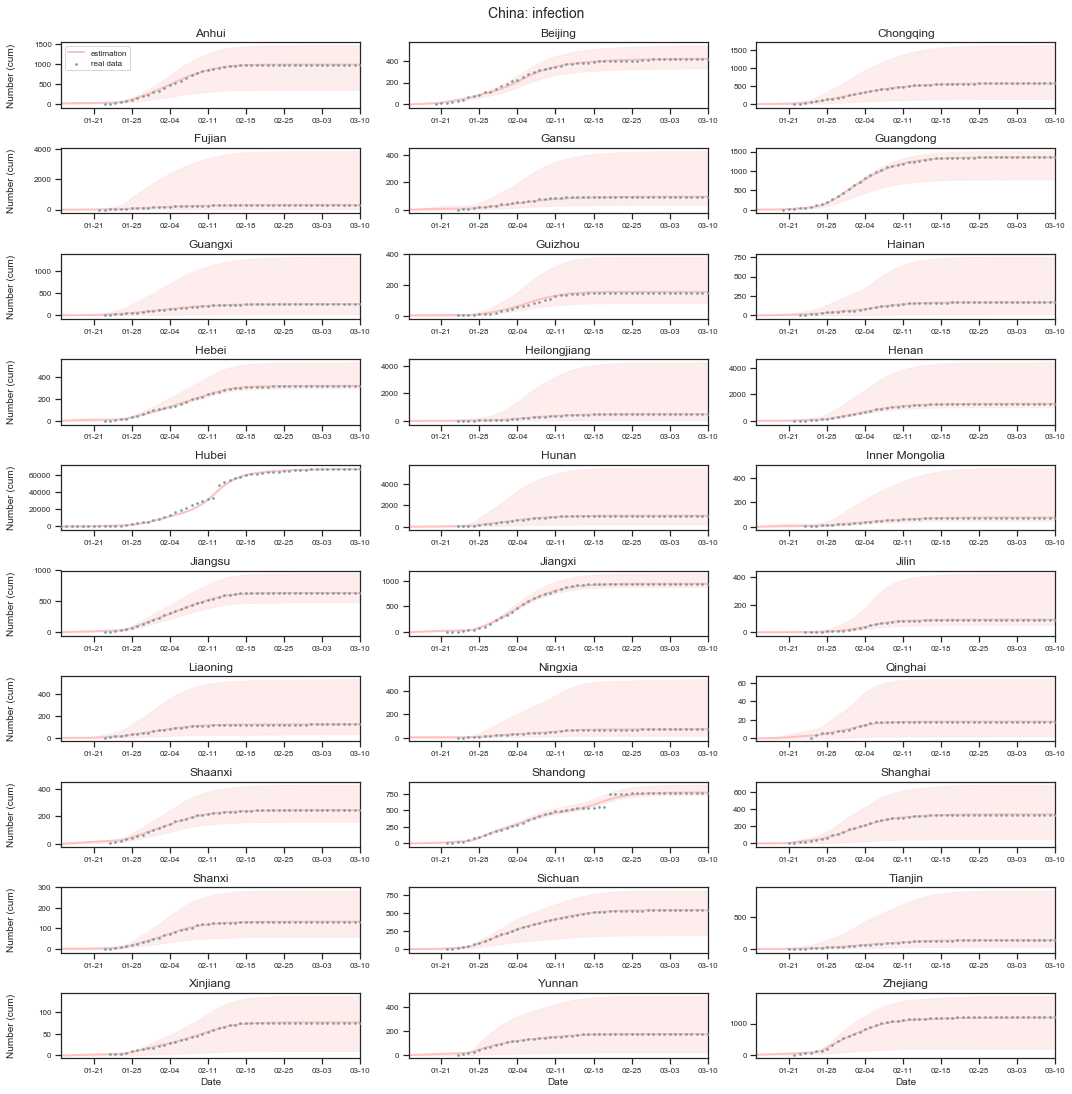

In [39]:
date_initial = min(data_province_domestic.update_date)
date_tr = datetime.date(int(2020),int(3),int(10))
figure_conf_est_all(data_province_domestic, names_province, date_tr, fsize = (5, 1.5), ncol = 3, ms = 3, fs = 12, 
                    title = 'China: infection', country = 'China', 
                    tag = 'with', repetition = rep)

In [230]:
# Chunyun 2020: from January 10 to February 18
date_initial = datetime.date(int(2020),int(1),int(1))
date_tr = datetime.date(int(2020),int(1),int(27))
pieces_lower = [{'min': 101},  # no max for this
               {'min': 51, 'max': 100},
               {'min': 21, 'max': 50},
               {'min': 11, 'max': 20},
               {'min': 5, 'max': 10},
               {'min': 0, 'max': 5}]
pieces_mid = [{'min': 501},  # no max for this
              {'min': 101, 'max': 500},
              {'min': 51, 'max': 100},
              {'min': 21, 'max': 50},
              {'min': 11, 'max': 20},
              {'min': 0, 'max': 10}]
vr_upper = [50, 100, 500]

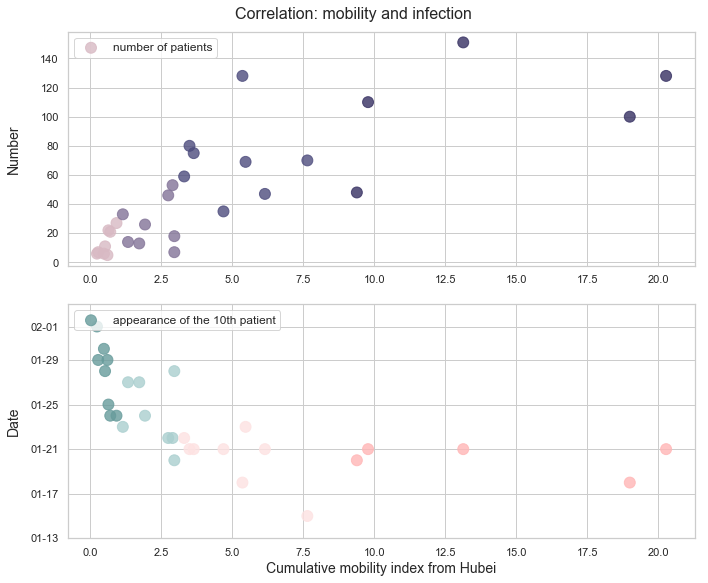

In [231]:
data_m_single, fig = correlation(10, 10, date_initial, date_tr, fs = 16, 
                                 pieces = pieces_mid, vr_upper = vr_upper[1], job = 'onset')

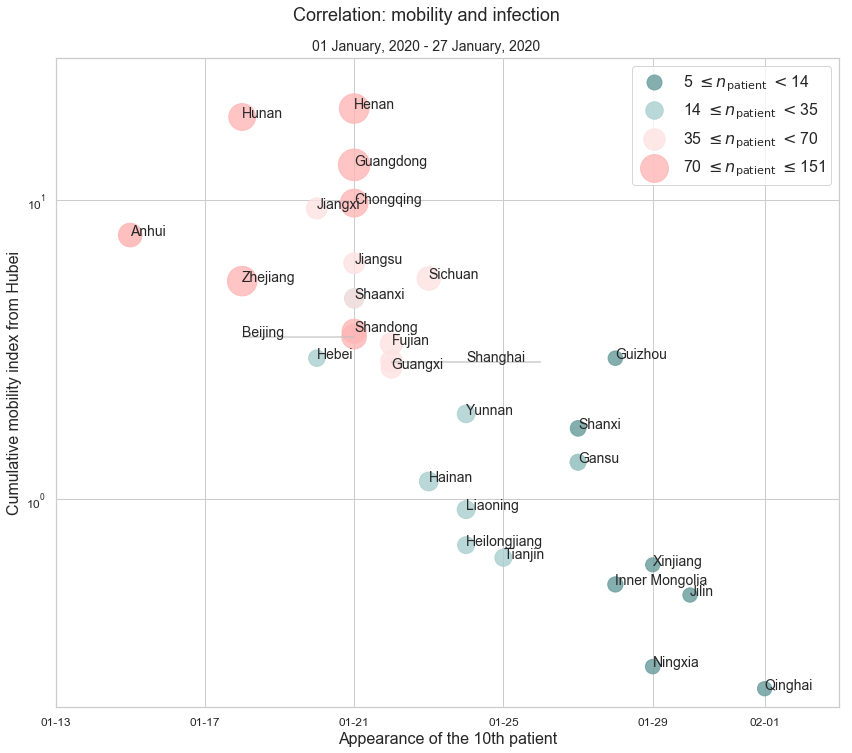

In [232]:
data_m_single, fig = correlation(10, 10, date_initial, date_tr, fs = 18, 
                                 pieces = pieces_mid, vr_upper = vr_upper[1], job = 'onset single')

In [233]:
date_tr = datetime.date(int(2020),int(1),int(27))
data_m_single, c = correlation(15, 10, date_initial, date_tr, 20,
                               pieces = pieces_mid, vr_upper = vr_upper[1], 
                               job = 'heatmap')

In [234]:
data_m_single, c = correlation(15, 3, date_initial, date_tr, 20,
                               pieces = pieces_mid, vr_upper = vr_upper[1], 
                               job = 'heatmap circle')

In [235]:
# with incubation
date_tr = datetime.date(int(2020),int(1),int(14))
data_m_single, c = correlation(15, 10, date_initial, date_tr, 20,
                               pieces = pieces_mid, vr_upper = 50, 
                               job = 'heatmap value', value = 0)

In [236]:
# with incubation
data_m_single, c = correlation(15, 3, date_initial, date_tr, 20,
                               pieces = pieces_mid, vr_upper = 50, 
                               job = 'heatmap circle value', value = 0)

In [237]:
date_tr = datetime.date(int(2020),int(1),int(27))
data_m_single, c = correlation_html(15, 10, date_initial, date_tr, 18,
                               pieces = pieces_mid, vr_upper = vr_upper[1], 
                               job = 'heatmap')
c.render_notebook()

In [238]:
data_m_single, c = correlation_html(15, 3, date_initial, date_tr, 12,
                               pieces = pieces_mid, vr_upper = vr_upper[1], 
                               job = 'heatmap circle')
c.render_notebook()

In [239]:
# with incubation
date_tr = datetime.date(int(2020),int(1),int(14))
data_m_single, c = correlation_html(15, 10, date_initial, date_tr, 18,
                               pieces = pieces_mid, vr_upper = 50, 
                               job = 'heatmap value', value = 0)
c.render_notebook()

In [240]:
# with incubation
data_m_single, c = correlation_html(15, 3, date_initial, date_tr, 12,
                               pieces = pieces_mid, vr_upper = 50, 
                               job = 'heatmap circle value', value = 0)
c.render_notebook()

In [292]:
# plot the prior (without mobility) and posterior (with mobility) estimations of E(0), I(0) or R(0)
def figure_parameters_bar(df_parameters_list, df_mparameters_list, 
                         fsize= (10, 6), fs = 16, title = r'$E_0$', country = 'China', target = 'E_0'):
    m = len(names_province)
    name_dict = {'E_0': 1, 'I_0': 2, 'R_0': 3} # which row the parameter lies in the dataframe of parameters
    bars = [df_parameters_list[i].loc[name_dict[target]].value for i in range(m)] # estimations without mobility
    mbars = [df_mparameters_list[i].loc[name_dict[target]].value for i in range(m)] # estimations with mobility
    bars_text = [round(temp) if temp >= 0.5 else round(temp, 4) for temp in bars]
    mbars_text = [round(temp) if temp >= 0.5 else round(temp, 4) for temp in mbars]
    bars_text = [int(temp) if temp >= 1 else temp for temp in bars_text]
    mbars_text = [int(temp) if temp >= 1 else temp for temp in mbars_text]
    bars = [round(temp) if temp >= 0.5 else 0.1 for temp in bars] # a rough rounding 
    mbars = [round(temp) if temp >= 0.5 else 0.1 for temp in mbars]
    

    fig = plt.figure(figsize = fsize)
    ax = plt.subplot(111)
    r = np.arange(m)
    
    sns.set_style("whitegrid")
    
    if target == 'E_0':
        palette = ['#d8b9c3', '#827397', '#4d4c7d', '#363062']
    else:
        palette = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
    
    
    df = data_province_domestic
    df_rank = df[df['update_date'] == datetime.date(int(2020),int(3),int(10))]
    df_rank = df_rank.sort_values(by = 'province_name_en') # same order as the list names_province
    df_rank = df_rank.reset_index(drop = True)
    df_rank = df_rank.sort_values(by = 'cum_confirmed')
    rank_list = df_rank.index.tolist()
    ################################################
    bars_text = [bars_text[i] for i in rank_list]
    mbars_text = [mbars_text[i] for i in rank_list]
    bars = [bars[i] for i in rank_list] # the order of provinces is ranked by the number of infections
    mbars = [mbars[i] for i in rank_list]
    
    if target == 'E_0':
        c = palette[1]
        for j in range(0, m):
            if bars[j] > mbars[j]: # if E(0) decreases
                ax.hlines(y = r[j], xmin = mbars[j], xmax = bars[j], color = c, linewidth = 5, alpha = 0.6, label = None)
                ax.text(x = mbars[j]*0.6, y = r[j] - 0.2, s = int(mbars[j]), size = fs - 4)
                ax.text(x = bars[j]*1.3, y = r[j] - 0.2, s = int(bars[j]), size = fs - 4)
                #ax.text(x = mbars[j]*0.6, y = r[j] - 0.2, s = mbars_text[j], size = fs - 4)
                #ax.text(x = bars[j]*1.3, y = r[j] - 0.2, s = bars_text[j], size = fs - 4)
                
        # get the cumulative mobility index from start_date to end_date
        start_date = datetime.date(int(2020),int(1),int(1))
        end_date = datetime.date(int(2020),int(1),int(14))
        data_m = data_network_P2P[(data_network_P2P.update_date >= start_date) & (data_network_P2P.update_date <= end_date)]
        data_m = data_m.drop(['update_date'], axis = 1)
        data_m = data_m.groupby(['source','target'])['value'].sum().reset_index() # adding up
        data_m_single = data_m[data_m.source == '湖北省'].sort_values(by = 'value') # from Hubei province to other province
        data_m_single = data_m_single.reset_index(drop = True)
        data_m_single = add_en_location(data_m_single, tag = 'network')
        s_list = [data_m_single[data_m_single['target_en'] == name]['value'].tolist()[0] if name != 'Hubei' else max(data_m_single['value']) for i, name in enumerate(df_rank['province_name_en'].values)]
        s_list = [item*50 + 50 for item in s_list]
        plt.scatter(bars, r, s = s_list, color = palette[0], alpha = 1, label = 'prior')
        plt.scatter(mbars, r, s = s_list, color = palette[3], alpha = 1, label = 'posterior')
    elif target == 'I_0':
        c = palette[1]
        for j in range(0, m):
            if bars[j] < mbars[j]: # if I(0) increasess
                ax.hlines(y = r[j], xmin = bars[j], xmax = mbars[j], color = c, linewidth = 5, alpha = 0.6, label = None)
                ax.text(x = bars[j]*0.65, y = r[j] - 0.2, s = int(bars[j]), size = fs - 4)
                ax.text(x = mbars[j]*1.3, y = r[j] - 0.2, s = int(mbars[j]), size = fs - 4)
        plt.scatter(bars, r, s = 100, color = palette[2], alpha = 1, label = 'prior')
        plt.scatter(mbars, r, s = 100, color = palette[3], alpha = 1, label = 'posterior')
    else:
        c = palette[2]
        for j in range(0, m):
            if bars[j] < mbars[j]: # if I(0) increasess
                ax.hlines(y = r[j], xmin = bars[j], xmax = mbars[j], color = c, linewidth = 5, alpha = 0.6, label = None)
                ax.text(x = bars[j]*0.7, y = r[j] - 0.2, s = int(bars[j]), size = fs - 4)
                ax.text(x = mbars[j]*1.3, y = r[j] - 0.2, s = int(mbars[j]), size = fs - 4)
                
        
        plt.scatter(bars, r, s = 100, color = palette[1], alpha = 1, label = 'prior')
        plt.scatter(mbars, r, s = 100, color = palette[0], alpha = 1, label = 'posterior')
    
    
    ax.legend(loc = 'upper center', ncol = 2, fontsize = fs, fancybox = True)
    plt.yticks(r, df_rank['province_name_en'].values)
    
    if target == 'E_0':
        ax.set_xscale('log')
        ax.set_xlim(0.04, 900)
        plt.xticks([0.1, 1, 10, 100], [0, 1, 10, 100])
    elif target == 'I_0':
        ax.set_xscale('log')
        ax.set_xlim(0.04, 250)
        plt.xticks([0.1, 1, 10, 100], [0, 1, 10, 100])
    else:
        ax.set_xscale('log')
        ax.set_xlim(0.04, 50)
        plt.xticks([0.1, 1, 10], [0, 1, 10])
    label_dict = {'E_0': r'$E(0)$', 'I_0': r'$I(0)$', 'R_0': r'$R(0)$'}
    ax.set_xlabel('Value', fontsize = fs)
    ax.set_ylabel("Province", fontsize = fs)
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 2)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 2)
    fig.suptitle(title, fontsize = fs + 2, y = 1.02)
    fig.savefig(_Figure_PATH_ + 'figures_china/' + country + '_' + target + '.png', dpi = 400, bbox_inches='tight')   
    return bars, mbars

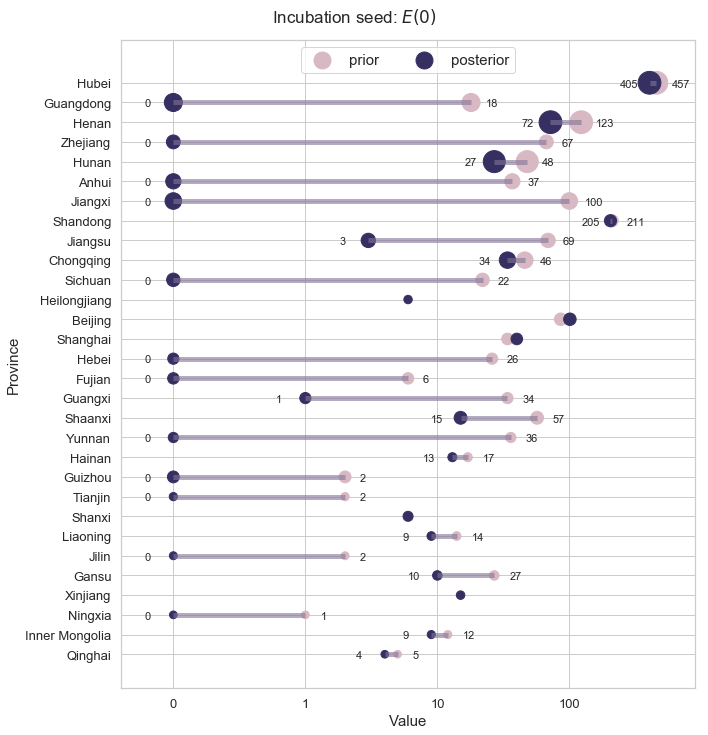

In [294]:
bars, mbars = figure_parameters_bar(df_parameters_list, df_mparameters_list,
                         fsize= (10, 10), fs = 15, title = 'Incubation seed: ' + r'$E(0)$', country = 'China', target = 'E_0')

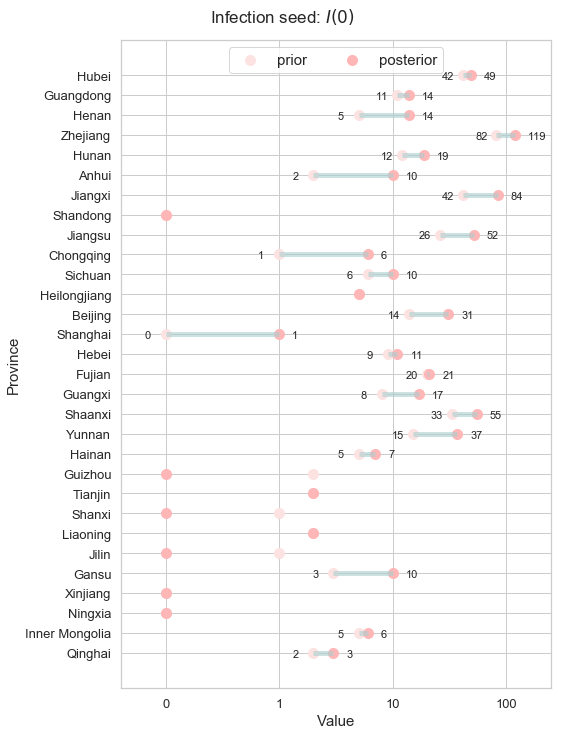

In [295]:
bars, mbars = figure_parameters_bar(df_parameters_list, df_mparameters_list,
                         fsize= (8, 10), fs = 15, title = 'Infection seed: ' + r'$I(0)$', country = 'China', target = 'I_0')

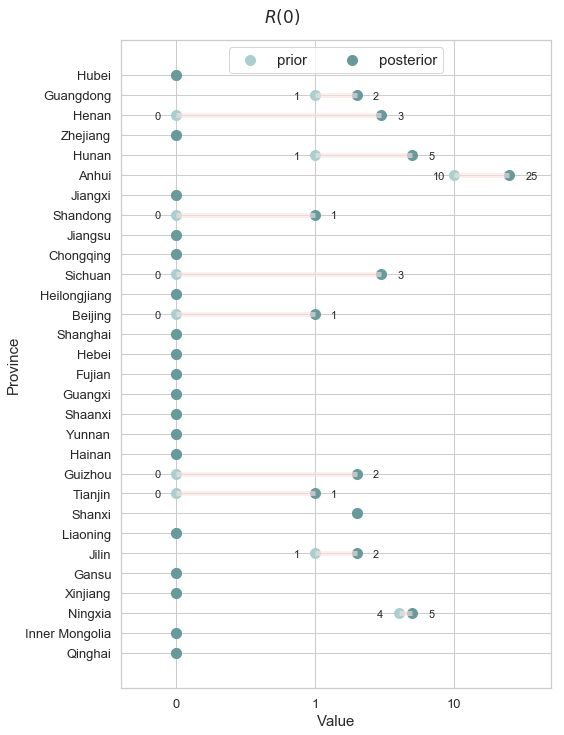

In [296]:
bars, mbars = figure_parameters_bar(df_parameters_list, df_mparameters_list,
                         fsize= (8, 10), fs = 15, title = r'$R(0)$', country = 'China', target = 'R_0')


* ## Contact rate 
## $\beta$

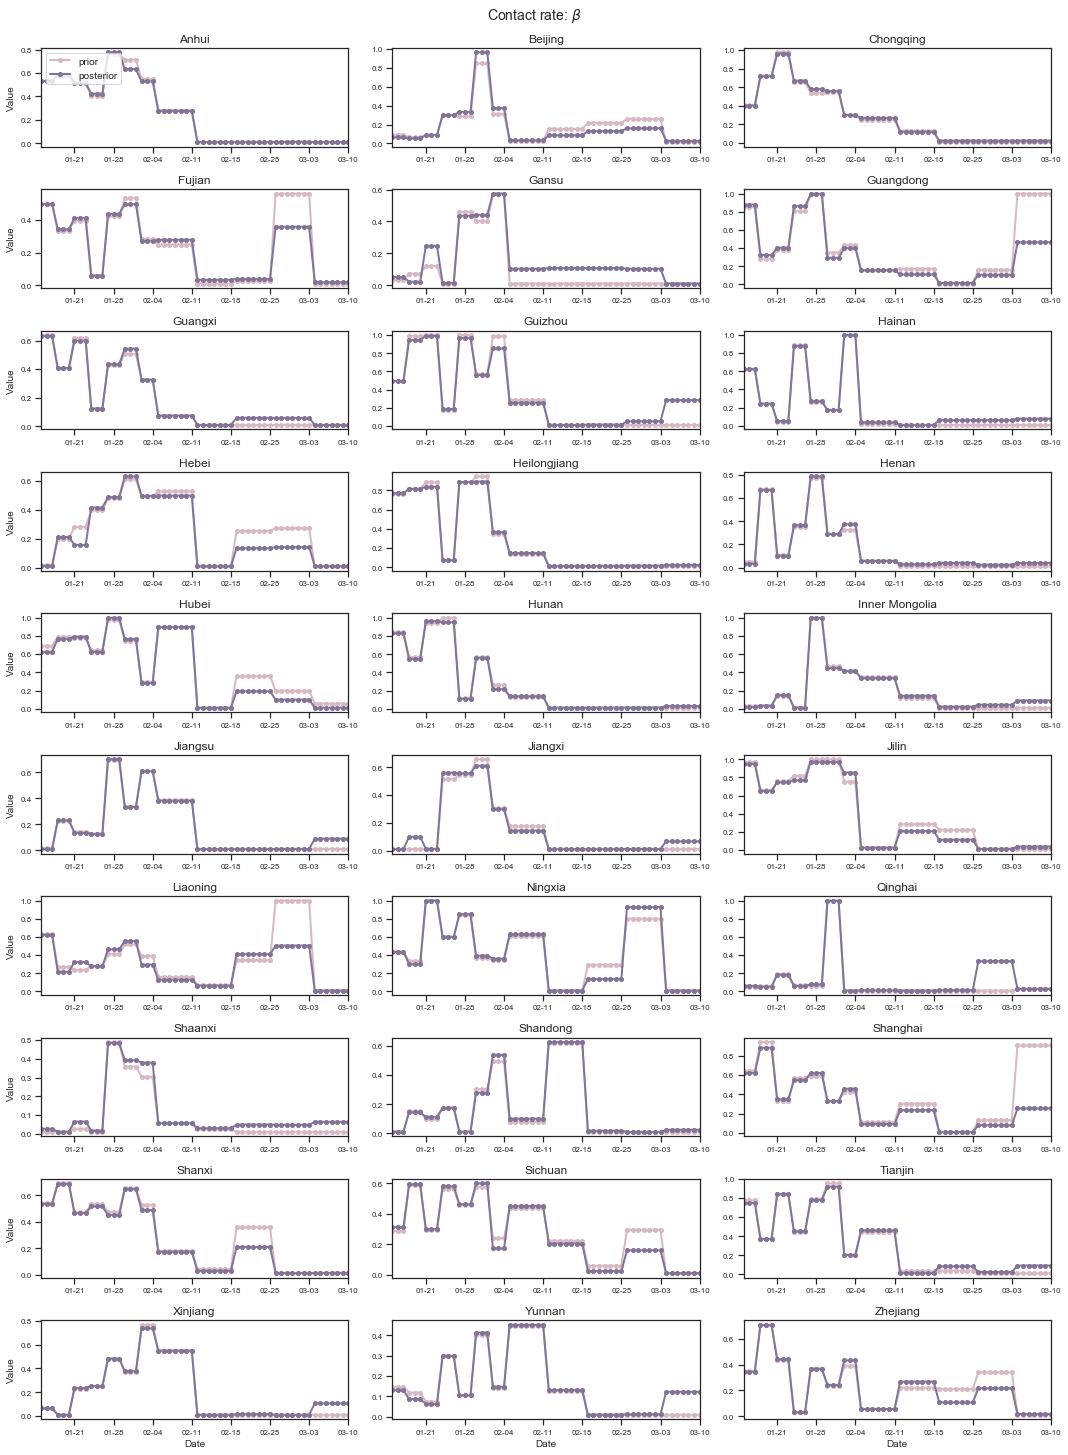

In [297]:
date_tr = datetime.date(int(2020),int(3),int(10))
figure_parameters(df_parameters_list, df_mparameters_list, df_estimation_list, 
                  names_province = names_province, update_date_tr = date_tr,
                  fsize = (5, 2), ncol = 3, ms = 4, fs = 12, 
                  title = r'Contact rate: $\beta$', country = 'China',
                  top = False, ndays = 56)

In [48]:
# plot the posterior (with mobility) estimations of beta and the interflow index
# calculate the lag and the cross correlation for every province
def figure_parameters_intra(df_mparameters_list, df_mestimation_list,
                            df_if, names_province, update_date_tr, ndays = 56, 
                            fsize = (5, 2), ncol = 3, ms = 2, fs = 10, title = None, country = 'China', top = False):
    
    date_initial = min(data_province_domestic['update_date'])
    
    df = data_province_domestic
    df_rank = df[df['update_date'] == max(df['update_date'])]
    df_rank = df_rank.sort_values(by = 'province_name_en') # same order as the list names_province
    df_rank = df_rank.reset_index(drop=True)
    df_rank = df_rank.sort_values(by = 'cum_confirmed')
    rank_list = df_rank.index.tolist()
    
    sns.set_style("ticks")
    palette_o = ['#d8b9c3', '#827397', '#4d4c7d', '#363062']
    palette = tealrose
    
    if top: # top 9 provinces
        df_single = data_province_domestic[data_province_domestic['update_date'] == max(data_province_domestic['update_date'])]
        names_province = df_single.sort_values(by = 'cum_confirmed', ascending = False).head(9).province_name_en.tolist()
        names_province.sort()
        
    m = len(names_province)
    
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (ncol*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.2, wspace = 0.1)
    
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
    for i, province in enumerate(names_province):
        mc = palette_o[1]
        df_mbeta = df_beta_gamma_sigma(df_mparameters_list, df_mestimation_list, i, 'beta', date_initial, update_date_tr)
    
        df_bgs = pd.DataFrame(columns = ['update_date', 'mbeta'])
        df_bgs['update_date'] = df_mbeta['update_date']
        df_bgs['mbeta'] = df_mbeta['value']

        ix = np.unravel_index(i, axes.shape)
        axes[ix].set_zorder(1) # default zorder is 0 for axes[ix] and its twin axis
        axes[ix].patch.set_visible(False) # prevents axes[ix] from hiding its twin axis 
        axes[ix].plot(df_bgs['update_date'], df_bgs['mbeta'],
                linewidth = 2, marker = 'o', ms = ms, color = mc, alpha = 1,
                      label = (lambda x: None if x > 0 else r'$\beta$')(i)) 
        
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            axes[ix].set_xlabel("Date", fontsize = fs - 2)
        if i % ncol == 0:
            axes[ix].set_ylabel("Value", fontsize = fs - 2)
        if i == 0:    
            axes[ix].legend(loc = 'upper left', ncol = 1, fancybox = True, fontsize = fs - 2)
    
    
    for i, province in enumerate(names_province):
        ix = np.unravel_index(i, axes.shape)
        ax_twin = axes[ix].twinx()
        ax_twin.grid(False)
        
        ccor, lag = cross_correlation(df_mparameters_list, df_mestimation_list, df_if, update_date_tr, i, ndays, printing = False)
        df_if_single = df_if[df_if['province_name_en'] == names_province[i]].copy()
        df_if_single = df_if_single[df_if_single['update_date'] >= datetime.date(int(2020),int(1),int(1))]
        df_if_single = df_if_single.reset_index(drop=True)
        df_if_single['update_date'] = df_if_single['update_date'] + timedelta(days = lag)  
        #print(min(df_if_single['update_date']))
        df_if_single = df_if_single[(df_if_single['update_date'] >= min(df_bgs.update_date)) & (df_if_single['update_date'] <= max(df_bgs.update_date))].copy()
        df_if_single = df_if_single.reset_index(drop=True)
        
        c = palette_o[0]
        # differenc response levels
        # before level 1
        df_if_single_0 = df_if_single[df_if_single['update_date'] < provincial_response_1_dict[province]].copy()
        ax_twin.plot(df_if_single_0['update_date'], df_if_single_0['n_value'],
                linewidth = 2, color = mc, alpha = 0.6, label = None)
        ax_twin.fill_between(df_if_single_0['update_date'], df_if_single_0['n_value'], min(df_if_single.n_value),
                                color = mc, alpha = 0.6, label = 'intra-province mobility')
        
        # level 1
        if provincial_response_2_dict[province] == None: # without level 2
            df_if_single_1 = df_if_single[(df_if_single['update_date'] >= provincial_response_1_dict[province]) & (df_if_single['update_date'] < provincial_response_3_dict[province])].copy()
            ax_twin.plot(df_if_single_1['update_date'], df_if_single_1['n_value'],
                linewidth = 2, color = palette[-2], alpha = 0.6, label = None)
            ax_twin.fill_between(df_if_single_1['update_date'], df_if_single_1['n_value'], min(df_if_single.n_value),
                                color = palette[-2], alpha = 0.6, label = 'class 1')
    
        else: # with level 2
            df_if_single_1 = df_if_single[(df_if_single['update_date'] >= provincial_response_1_dict[province]) & (df_if_single['update_date'] < provincial_response_2_dict[province])].copy()
            df_if_single_2 = df_if_single[(df_if_single['update_date'] >= provincial_response_2_dict[province]) & (df_if_single['update_date'] < provincial_response_3_dict[province])].copy()
            ax_twin.plot(df_if_single_1['update_date'], df_if_single_1['n_value'],
                linewidth = 2, color = palette[-2], alpha = 0.6, label = None)
            ax_twin.fill_between(df_if_single_1['update_date'], df_if_single_1['n_value'], min(df_if_single.n_value),
                                color = palette[-2], alpha = 0.6, label = 'class 1')
            ax_twin.plot(df_if_single_2['update_date'], df_if_single_2['n_value'],
                linewidth = 2, color = palette[3], alpha = 0.6, label = None)
            ax_twin.fill_between(df_if_single_2['update_date'], df_if_single_2['n_value'], min(df_if_single.n_value),
                                color = palette[3], alpha = 0.6, label = 'class 2')
        # level 3
        df_if_single_3 = df_if_single[df_if_single['update_date'] >= provincial_response_3_dict[province]].copy()
        ax_twin.plot(df_if_single_3['update_date'], df_if_single_3['n_value'],
                linewidth = 2, color = palette[1], alpha = 0.6, label = None)
        ax_twin.fill_between(df_if_single_3['update_date'], df_if_single_3['n_value'], min(df_if_single.n_value),
                             color = palette[1], alpha = 0.6, label = 'class 3')
            
        
        #ax_twin.plot(df_if_single['update_date'], df_if_single['n_value'],
                #linewidth = 2, color = c, alpha = 0.6, label = None)
        #ax_twin.fill_between(df_if_single['update_date'], df_if_single['n_value'], min(df_if_single.n_value),
                                #color = c, alpha = 0.4, label = 'intra-province mobility')
        hand, label = ax_twin.get_legend_handles_labels()
        if i == 0:
            ax_twin.legend(hand[4:5], label[4:5], loc = 'upper right', fancybox = True, fontsize = fs - 2)
            
        if i == 1:
            patch_0 = mpatches.Patch(color = palette_o[1], label = 'no response')
            patch_1 = mpatches.Patch(color = palette[-2], label = 'level 1')
            patch_2 = mpatches.Patch(color = palette[3], label = 'level 2')
            patch_3 = mpatches.Patch(color = palette[1], label = 'level 3')

            axes[ix].legend(handles=[patch_0, patch_1, patch_2, patch_3], loc='upper center', bbox_to_anchor=(0.5, 1.8), 
                            ncol = 4, fancybox = True, fontsize = fs - 2)
            
        ax_twin.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        ax_twin.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        if i % ncol == ncol - 1:
            ax_twin.set_ylabel('Ratio', fontsize = fs - 2)
        
        ax_twin.get_yaxis().set_label_coords(1.1, 0.5)
            
        axes[ix].tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        axes[ix].tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        if i == 0:
            adding = ' (lag = ' + str(lag) + ', ccor = ' + str(round(ccor,4)) + ')'
        else:
            adding = ' (' + str(lag) + ', ' + str(round(ccor, 4)) + ')'
        axes[ix].set_title(province + adding, fontsize = fs)
        axes[ix].set_xlim(min(df_bgs.update_date), min(df_bgs.update_date) + timedelta(days = ndays-1))
        axes[ix].xaxis.set_major_locator(mdates.WeekdayLocator())
        axes[ix].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        
            
    fig.align_ylabels(axes[:, 0])    
    fig.suptitle(title, fontsize = fs + 2, y = 1.015)
        
    fig.savefig(_Figure_PATH_ + 'figures_china/' + country + '_intra_beta.png', dpi = 400, bbox_inches='tight')   

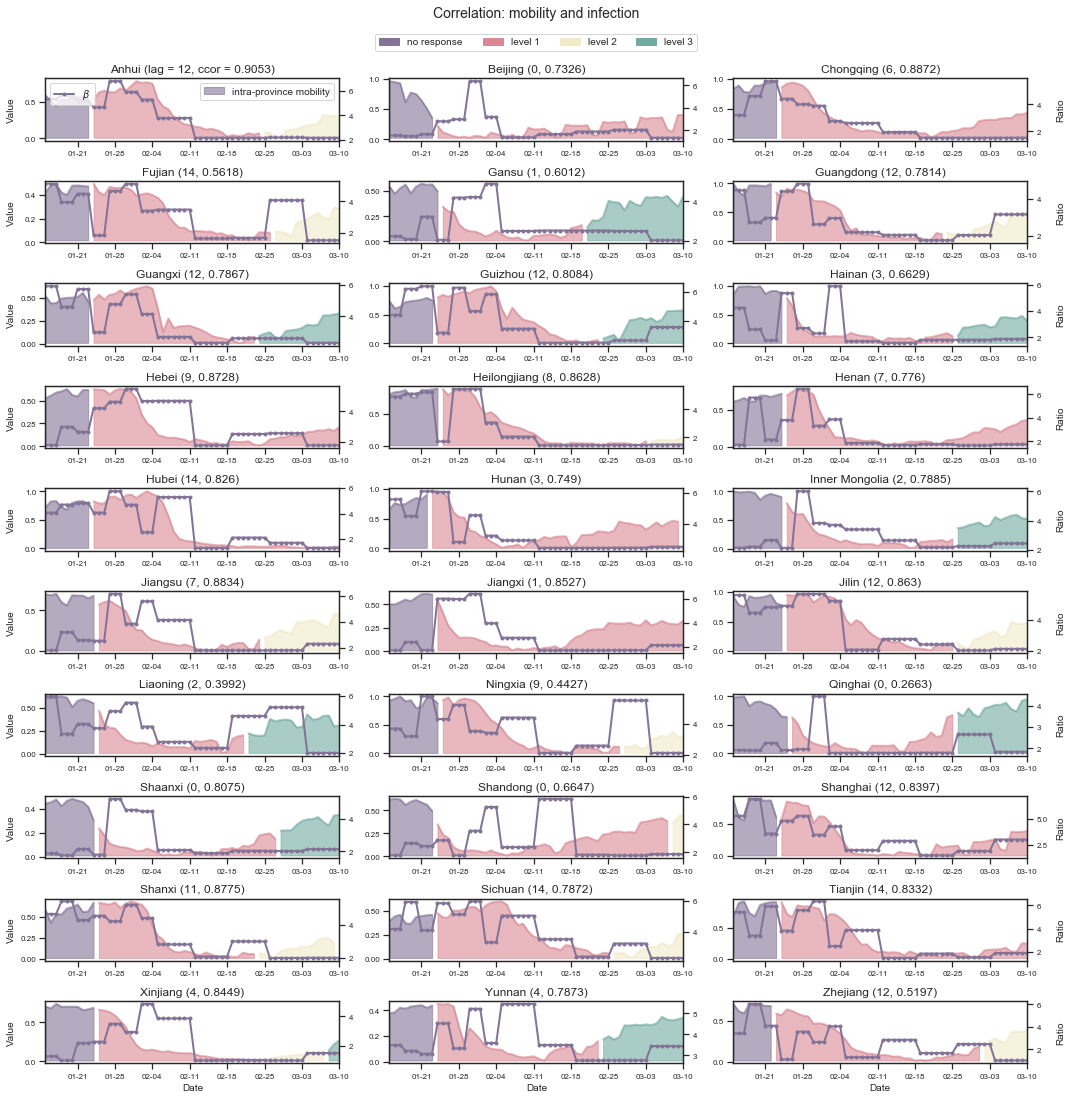

In [49]:
date_tr = datetime.date(int(2020),int(3),int(10))
# ndays: only keep the data of the first ndays
figure_parameters_intra(df_mparameters_list, df_mestimation_list,
                     data_if_province, names_province, date_tr, ndays = 56, 
                     fsize = (5, 1.5), ncol = 3, ms = 3, fs = 12, 
                     title = 'Correlation: mobility and infection', country = 'China', top = False)

In [300]:
ccor_list = []
for i, name in enumerate(names_province):
    ccor, lag = cross_correlation(df_mparameters_list, df_mestimation_list, data_if_province, date_tr, i, ndays = 56, printing = False)
    ccor_list.append(ccor)
np.sum([1 if item >= 0.7 else 0 for item in ccor_list]), min(ccor_list)  

(22, 0.26630093801740445)

In [52]:
data_response_o, data_response = load_response_raw()

In [53]:
data_response_o['date_level1'].min(), data_response_o['date_level3'].max()

(datetime.date(2020, 1, 23), datetime.date(2020, 6, 13))

In [54]:
data_response_o

,province_name,date_level1,date_level2,date_level3
0,Anhui,2020-01-24,2020-02-25,2020-03-15
1,Beijing,2020-01-24,2020-04-30,2020-06-06
2,Chongqing,2020-01-24,2020-03-11,2020-03-25
3,Fujian,2020-01-24,2020-02-27,2020-03-19
4,Gansu,2020-01-25,None,2020-02-21
5,Guangdong,2020-01-23,2020-02-24,2020-05-09
6,Guangxi,2020-01-24,None,2020-02-24
7,Guizhou,2020-01-24,None,2020-02-24
8,Hainan,2020-01-25,None,2020-02-26
9,Hebei,2020-01-24,2020-04-30,2020-06-06


In [55]:
# Plot the response dates
def figure_response_plotly(df_response, fs):
    palette = tealrose
    cmap = [palette[-2], palette[3], palette[1]]
    fig = px.timeline(df_response[df_response['province_name']!='Tibet'].sort_values(['province_name', 'level'], ascending=False), x_start="start_date", x_end="end_date", y="province_name", color="level",
                      color_discrete_map={'Class 1': cmap[0], 'Class 2': cmap[1], 'Class 3': cmap[2]},
                      opacity = 0.8,
                      hover_name="province_name", hover_data={'province_name': False,'level': False})
    fig.update_xaxes(tickformat = '%m-%d', dtick=86400000*14, tick0=datetime.datetime(2020, 1, 27))
    fig.update_yaxes(nticks=30)
    fig.update_traces(width=0.3)
    fig.update_xaxes(showgrid=True, gridwidth=1, linewidth=1.5) # gridcolor='#DCDCDC', 
    fig.update_yaxes(showgrid=False, linewidth=1.5)
    fig.update_layout(
        template="plotly_white",
        xaxis={'mirror': True, 'showline': True}, #'ticks': 'inside', 
        yaxis={'mirror': True, 'showline': True},
        width=900, height=800, margin = dict(t = 60),
        xaxis_range=[datetime.datetime(2020, 1, 20), datetime.datetime(2020, 6, 16)],
        xaxis_title="Date",
        yaxis_title="Province",
        title={
            'text': "China: response to public health emergency", 'x':0.5, 'y': 0.99, 'xanchor': 'center', 'yanchor': 'top'}, 
        font={'size': 14},
        titlefont={"size": 18},
        legend={'title': '', 'traceorder':'reversed', 'orientation': 'h', 'x': 0.5, 'y': 1.055, 'xanchor': 'center', 'yanchor': 'top'}
    )
    fig.show()
    fig.update_layout(
        width=1800, height=1600, margin = dict(l = 60, r = 60, t = 120, b = 60), font={'size': fs}, titlefont={"size": fs + 4}, legend={'y': 1.045})
    fig.write_image(_Figure_PATH_ + 'figures_china/' + 'China_response.png')
    return fig

In [56]:
#fig = figure_response_plotly(data_response, fs = 28)

In [57]:
def figure_response(df_response, update_date_tr, fsize, fs):
    
    df = df_response.copy()
    date_start = df['date_level1'].min() 
    date_end = df['date_level3'].max() + timedelta(days = 2)
    df['level 0'] = df['date_level1'] - date_start
    df['level 1'] = df.apply (lambda row: row['date_level3'] - row['date_level1'] 
                              if row['date_level2'] == None else row['date_level2'] - row['date_level1'], 
                              axis = 1)
    df['level 2'] = df.apply (lambda row: timedelta(days = 0) if row['date_level2'] == None else row['date_level3'] - row['date_level2'], 
                              axis = 1)
    df['level 3'] = date_end - df['date_level3']
    df['level 0'] = df['level 0'].dt.days
    df['level 1'] = df['level 1'].dt.days
    df['level 2'] = df['level 2'].dt.days
    df['level 3'] = df['level 3'].dt.days
    df = df[['province_name', 'level 0', 'level 1', 'level 2', 'level 3']].copy()
    df = df.set_index('province_name')

    fig, ax = plt.subplots(figsize = fsize)
    sns.set_style("whitegrid")
    ax.set_zorder(0)

    palette = tealrose
    df.plot.barh(stacked = True, ax = ax, width = 0.4, color = ['#FFFFFF', palette[-2], palette[3], palette[1]], alpha = 0.8)
        
    ax.set_xlabel('Date', fontsize = fs - 2)
    ax.set_ylabel('Province', fontsize = fs - 2)
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)        
    ax.set_title("China: response to public health emergency", fontsize = fs, y = 1.07)
    hand, label = ax.get_legend_handles_labels()
    ax.legend(hand[1:], label[1:], loc='upper center', bbox_to_anchor=(0.5, 1.06), fancybox = True, 
              ncol = 3, fontsize = fs - 4)
    ax.invert_yaxis()

    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 15))
    ax.set_xlim(start, end)
    labels = ax.get_xticks().tolist()
    labels = [date_start + timedelta(days = v) for v in labels]
    labels = [v.strftime('%m-%d') for v in labels]
    ax.set_xticklabels(labels)
    ax.xaxis_date()
    fig.savefig(_Figure_PATH_ + 'figures_china/' + 'China_response.png', dpi = 400, bbox_inches='tight')   
    

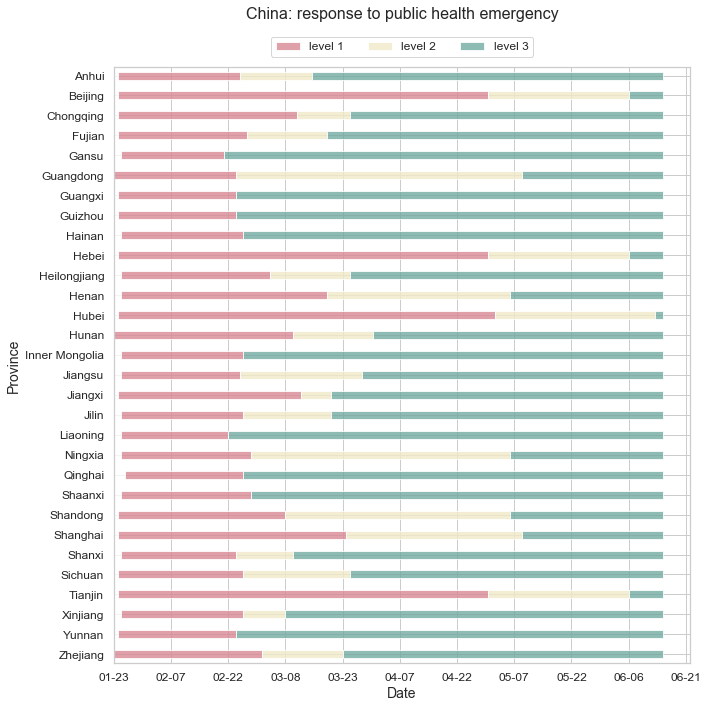

In [370]:
figure_response(data_response_o, date_tr, (10, 10), 16)

In [60]:
def figure_parameters_response(df_mparameters_list, df_mestimation_list, df_response, update_date_tr, fsize, fs, title, country):
    fig, ax = plt.subplots(figsize = fsize)
    sns.set_style("whitegrid")
    palette_o = ['#d8b9c3', '#827397', '#4d4c7d', '#363062']
    palette = tealrose
    date_initial = min(data_province_domestic['update_date'])
    
    for i, province in enumerate(names_province):
        df_mbeta = df_beta_gamma_sigma(df_mparameters_list, df_mestimation_list, i, 'beta', date_initial, update_date_tr)
        df_bgs = pd.DataFrame(columns = ['update_date', 'value'])
        df_bgs['update_date'] = df_mbeta['update_date']
        df_bgs['value'] = df_mbeta['value']

        x = pd.date_range(date_initial.strftime("%Y-%m-%d"), update_date_tr.strftime("%Y-%m-%d"), freq="1D" )
        y = np.zeros(x.size) + i
        s = pd.Series(y, index = x)
        lwidths = 2.5 + 12.5*df_bgs['value'].to_numpy()[:-1]
        x = mdates.date2num(s.index.to_pydatetime())
        points = np.array([x, s.values]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        date_1, date_2, date_3 = df_response[df_response['province_name'] == province].values.tolist()[0][1:]
        if date_2 == None:
            cmap = [palette_o[1]]*(date_1 - date_initial).days + [palette[-2]]*(date_3 - date_1).days + [palette[1]]*(update_date_tr - date_3).days
        else:
            cmap = [palette_o[1]]*(date_1 - date_initial).days + [palette[-2]]*(date_2 - date_1).days + [palette[3]]*(date_3 - date_2).days + [palette[1]]*(update_date_tr - date_3).days
        lc = LineCollection(segments, linewidths = lwidths, color = cmap)
        ax.add_collection(lc)
    ax.set_xlim(date_initial, update_date_tr)
    ax.set_ylim(-2, 29.5)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.invert_yaxis()
    m = len(names_province)
    ax.yaxis.set_ticks(range(0, m))
    ax.set_yticklabels(names_province)

    ax.set_xlabel('Date', fontsize = fs - 2)
    ax.set_ylabel('Province', fontsize = fs - 2)
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)   

    patch_0 = mpatches.Patch(color = palette_o[1], label = 'no response')
    patch_1 = mpatches.Patch(color = palette[-2], label = 'level 1')
    patch_2 = mpatches.Patch(color = palette[3], label = 'level 2')
    patch_3 = mpatches.Patch(color = palette[1], label = 'level 3')
    patch_min = mpatches.Rectangle((0, 0), 2.5, 2.5, fc = palette[-2], fill = True, edgecolor = 'none', linewidth = 0)
    patch_max = mpatches.Rectangle((0, 0), 10, 10, fc = palette[-2], fill = True, edgecolor = 'none', linewidth = 0)
    #lines = [Line2D([0], [0], color = palette[-2], linewidth = 0)]
    lines = []
    lines += [Line2D([0], [0], color = palette[-2], linewidth = 2.5 + 12.5*beta) for beta in [0.01, 0.1, 1]]
    #labels = [r'$\beta$: ', '0.01', '0.1', '1']
    labels = [r'$\beta$ = ' + '0.01', ' ' + '0.1', ' '  + '1']
    leg = plt.legend(handles = [patch_0, patch_1, patch_2, patch_3], loc = 'upper center', bbox_to_anchor = (0.5, 1.06), fancybox = True, 
                  ncol = 4, fontsize = fs - 4)
    
    plt.gca().add_artist(leg)
    leg_beta = plt.legend(lines, labels, loc = 'upper center', bbox_to_anchor = (0.5, 1.01), frameon = False, ncol = 3, fontsize = fs - 4)
    

    ax.set_title("China: response and contact rate", fontsize = fs, y = 1.07)
    
    fig.savefig(_Figure_PATH_ + 'figures_china/' + country + '_response_beta.png', dpi = 400, bbox_inches='tight')   
    
    

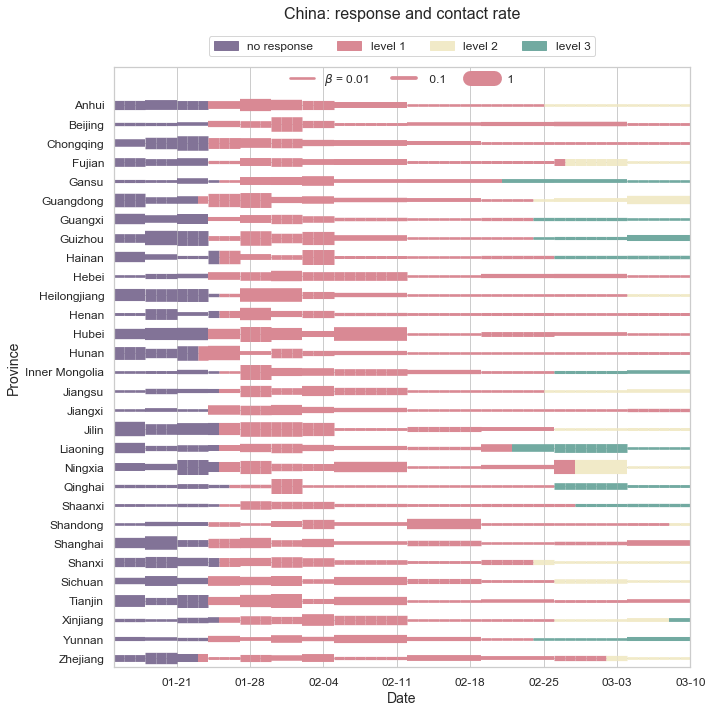

In [61]:
date_tr = datetime.date(2020, 3, 10)
figure_parameters_response(df_mparameters_list, df_mestimation_list, data_response_o, date_tr, 
                           fsize = (10, 10), fs = 16, title = None, country = 'China')

* ## Basic Reproduction Number
## $R_0$

In [62]:
def figure_br_number(df_mparameters_list, df_mestimation_list,
                     df_if, names_province, update_date_tr, ndays = 56, 
                     fsize = (5, 1.5), ncol = 3, ms = 2, fs = 10, title = None, country = 'China', top = False):
    
    date_initial = min(data_province_domestic['update_date'])
    
    df = data_province_domestic
    df_rank = df[df['update_date'] == max(df['update_date'])]
    df_rank = df_rank.sort_values(by = 'province_name_en') # same order as the list names_province
    df_rank = df_rank.reset_index(drop = True)
    df_rank = df_rank.sort_values(by = 'cum_confirmed')
    rank_list = df_rank.index.tolist()
    
    sns.set_style("ticks")
    palette_o = ['#d8b9c3', '#827397', '#4d4c7d', '#363062']
    palette = tealrose
    
    if top: # top 9 provinces
        df_single = data_province_domestic[data_province_domestic['update_date'] == max(data_province_domestic['update_date'])]
        names_province = df_single.sort_values(by = 'cum_confirmed', ascending = False).head(9).province_name_en.tolist()
        names_province.sort()
        
    m = len(names_province)
    lw = 3
    a, b = 0.6, 0.6
    
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (ncol*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.2, wspace = 0.1)
    
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
    for i, province in enumerate(names_province):
        
        df_single = df_beta_gamma_sigma(df_mparameters_list, df_mestimation_list, i, 'R_0', date_initial, update_date_tr)

        ix = np.unravel_index(i, axes.shape)
        
        ax = axes[ix]
        
        # differenc response levels
        # before level 1 (include "= provincial_response_1_dict[province]")
        df_single_0 = df_single[df_single['update_date'] < provincial_response_1_dict[province]].copy()
        ax.plot(df_single_0['update_date'], df_single_0['value'], linewidth = lw, color = palette_o[1], alpha = a, label = None)
        ax.fill_between(df_single_0['update_date'], df_single_0['value'], 0, color = palette_o[1], alpha = a, label = 'no response')
        
        # level 1 (include "= provincial_response_3_dict[province]")
        if provincial_response_2_dict[province] == None: # without level 2
            df_single_1 = df_single[(df_single['update_date'] >= provincial_response_1_dict[province]) & (df_single['update_date'] < provincial_response_3_dict[province])].copy()
            ax.plot(df_single_1['update_date'], df_single_1['value'], linewidth = lw, color = palette[-2], alpha = a, label = None)
            axes[ix].fill_between(df_single_1['update_date'], df_single_1['value'], 0, color = palette[-2], alpha = a, label = 'class 1')
            
        else: # with level 2 (include "= provincial_response_2_dict[province]")
            df_single_1 = df_single[(df_single['update_date'] >= provincial_response_1_dict[province]) & (df_single['update_date'] < provincial_response_2_dict[province])].copy()
            df_single_2 = df_single[(df_single['update_date'] >= provincial_response_2_dict[province]) & (df_single['update_date'] < provincial_response_3_dict[province])].copy()
            ax.plot(df_single_1['update_date'], df_single_1['value'], linewidth = lw, color = palette[-2], alpha = a, label = None)
            ax.fill_between(df_single_1['update_date'], df_single_1['value'], 0, color = palette[-2], alpha = a, label = 'class 1')
            ax.plot(df_single_2['update_date'], df_single_2['value'], linewidth = lw, color = palette[3], alpha = a, label = None)
            ax.fill_between(df_single_2['update_date'], df_single_2['value'], 0, color = palette[3], alpha = a, label = 'class 2')
        
        # level 3
        df_single_3 = df_single[df_single['update_date'] >= provincial_response_3_dict[province]].copy()
        ax.plot(df_single_3['update_date'], df_single_3['value'], linewidth = lw, color = palette[1], alpha = a, label = None)
        ax.fill_between(df_single_3['update_date'], df_single_3['value'], 0, color = palette[1], alpha = a, label = 'class 3')
        
        
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            ax.set_xlabel("Date", fontsize = fs - 2)
        if i % ncol == 0:
            ax.set_ylabel("Value", fontsize = fs - 2)
        if i == 1:
            patch_0 = mpatches.Patch(color = palette_o[1], label = 'no response')
            patch_1 = mpatches.Patch(color = palette[-2], label = 'level 1')
            patch_2 = mpatches.Patch(color = palette[3], label = 'level 2')
            patch_3 = mpatches.Patch(color = palette[1], label = 'level 3')

            axes[ix].legend(handles=[patch_0, patch_1, patch_2, patch_3], loc='upper center', bbox_to_anchor=(0.5, 1.8), 
                            ncol = 4, fancybox = True, fontsize = fs - 2)
        
        ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        
        ax.set_title(province, fontsize = fs)
        ax.set_xlim(min(df_single.update_date), min(df_single.update_date) + timedelta(days = ndays-1))
        ax.xaxis.set_major_locator(mdates.WeekdayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
            
    fig.align_ylabels(axes[:, 0])    
    
    fig.suptitle(title, fontsize = fs + 2, y = 1.015) 
    fig.savefig(_Figure_PATH_ + 'figures_china/' + country + '_br_number.png', dpi = 400, bbox_inches='tight')   

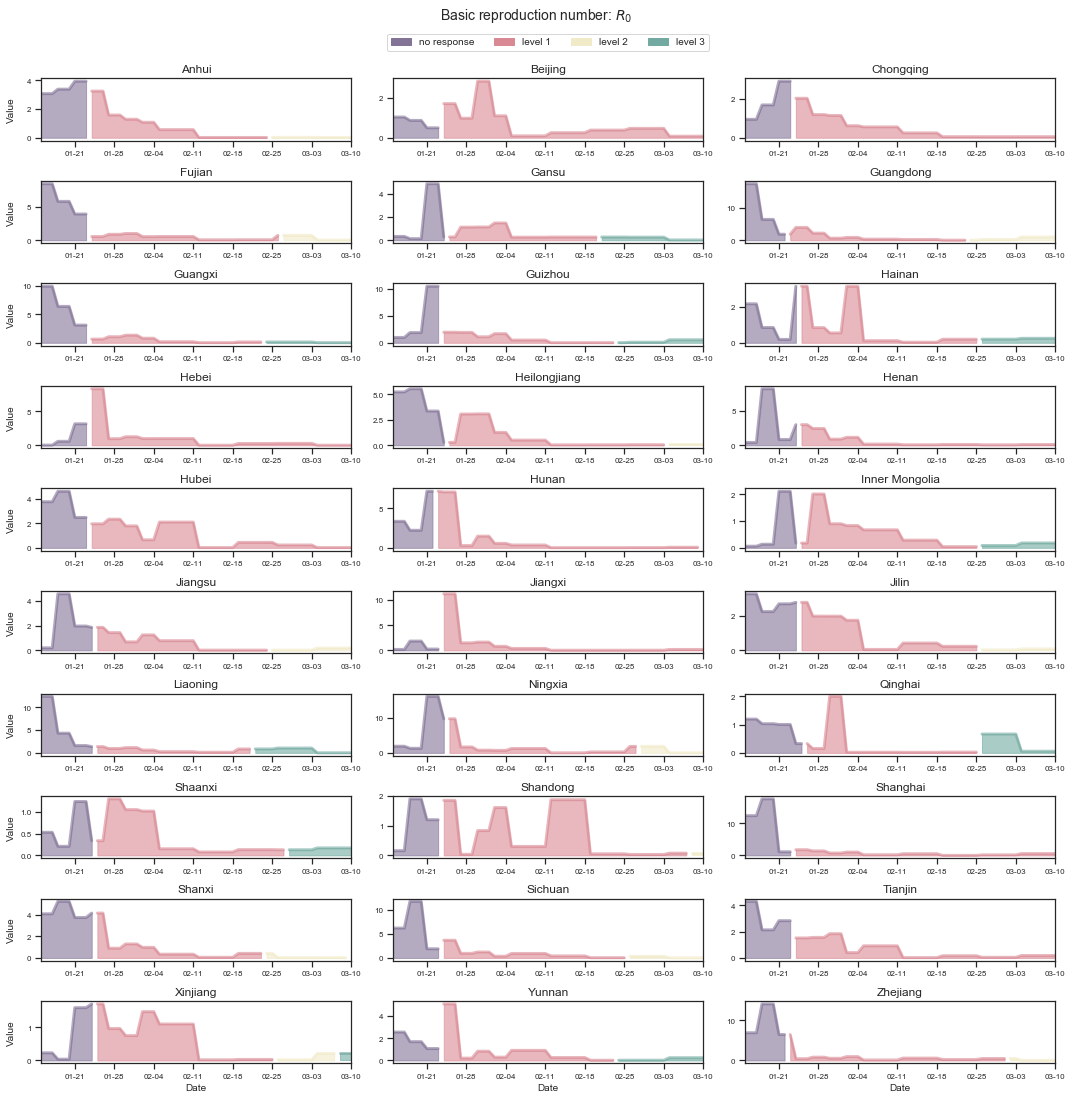

In [63]:
date_tr = datetime.date(int(2020),int(3),int(10))
# ndays: only keep the data of the first ndays
figure_br_number(df_mparameters_list, df_mestimation_list,
                        data_if_province, names_province, date_tr, ndays = 56, 
                        fsize = (5, 1.5), ncol = 3, ms = 3, fs = 12, 
                        title = 'Basic reproduction number: ' + r'$R_0$', country = 'China', top = False)

In [311]:
def figure_logistic(df, df_mparameters_all, update_date_tr, mindex_list, fitting,
                    fsize = (5, 1.5), ncol = 3, ms = 2, fs = 10, title = None, country = 'China'):
    
    n_parameters = df_mparameters_list[0].shape[0]
    
    def log_func(t, K, P0, r):
        return K/(1 + (K - P0)/P0*np.exp(-r*t))
    def exp_func(t, a, b, r):
        return a*np.exp(r*t) + b
    def power_func(t, a, b, r):
        return a*np.power(t, r) + b
    
    m = len(names_province)
    lw = 3
    a, b = 0.6, 0.6
    palette_o = ['#d8b9c3', '#827397', '#4d4c7d', '#363062']
    palette = tealrose
    
    
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (ncol*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.2, wspace = 0.1)
    
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
    for i, province in enumerate(names_province):
        
        # let E_i(0) = 1
        # fit an exponential growth to I, and get the exponent for the growth rate
        df_mparameters_all_o = df_mparameters_all.copy()

        for j, prov in enumerate(names_province):
            if j!= i:
                df_mparameters_all_o.at[2 + j*n_parameters, 'value'] = 0 # E_j(0) = 0
                
            else:
                df_mparameters_all_o.at[2 + j*n_parameters, 'value'] = 1 # E_i(0) = 1
                
            df_mparameters_all_o.at[3 + j*n_parameters, 'value'] = 0 # I(0) = 0
            df_mparameters_all_o.at[4 + j*n_parameters, 'value'] = 0 # R(0) = 0
            
            df_mparameters_all_o.at[5 + j*n_parameters, 'value'] = (df_mparameters_all_o.at[1 + j*n_parameters, 'value'] - 
                                                                    df_mparameters_all_o.at[2 + j*n_parameters, 'value'] - 
                                                                    df_mparameters_all_o.at[3 + j*n_parameters, 'value'] - 
                                                                    df_mparameters_all_o.at[4 + j*n_parameters, 'value'])
            
        est_S, est_E, est_I, est_R = ode_state(df = df, df_mparameters_state = df_mparameters_all_o, 
                                               update_date_tr = update_date_tr, mindex_list = mindex_list, T = 21, TT = 6, TI = 3, ti = 7, 
                                               sample = -1)

        est_I_cum = np.cumsum(est_I, axis = 0)
        ts = range(0, est_I_cum.shape[0])
        ts_date = [item for item in daterange(min(df.update_date), update_date_tr)]
        
        ix = np.unravel_index(i, axes.shape)
        ax = axes[ix]
        
        y = np.sum(est_I_cum, axis = 1) # sum up I_cum for all provinces
        ax.scatter(ts_date, y, color = palette_o[3], s = 6, label = r'$\sum I_i(t)$', zorder = 100)
        
        if fitting == 'log':
            params = curve_fit(log_func, ts, y, maxfev = np.power(10, 6))
            [K, P0, r] = params[0]
            y_log = log_func(ts, K, P0, r)
            K_s = str(round(K, 2))
            P0_s = str(round(P0, 2))
            r_s = str(round(r, 2))
            ax.plot(ts_date, y_log, linewidth = 3, color = palette_o[0], label = 'logistic')
        elif fitting == 'exp':
            head = 0
            tail = 21
            params = curve_fit(exp_func, ts[head:tail], y[head:tail], maxfev = 5000)
            [a, b, r] = params[0]
            y_exp = exp_func(ts[head:tail], a, b, r)
            a_s = str(round(a, 2))
            b_s = str(round(b, 2))
            r_s = str(round(r, 2))
            ax.plot(ts_date[head:tail], y_exp, linewidth = 3, color = palette_o[0], label = r'$ae^{rt} + b$')
        elif fitting == 'power':
            head = 0
            tail = 21
            params = curve_fit(power_func, ts[head:tail], y[head:tail], maxfev = 5000)
            [a, b, r] = params[0]
            y_power = power_func(ts[head:tail], a, b, r)
            a_s = str(round(a, 2))
            b_s = str(round(b, 2))
            r_s = str(round(r, 2))
            ax.plot(ts_date[head:tail], y_power, linewidth = 3, color = palette_o[0], label = r'$at^r + b$')

        if i >= (np.ceil(m/ncol) - 1)*ncol:
            ax.set_xlabel("Date", fontsize = fs - 2)
        if i % ncol == 0:
            ax.set_ylabel("Value", fontsize = fs - 2)
        if i == 0:
            ax.legend(loc = 'upper left', ncol = 1, fancybox = True, fontsize = fs - 2)
    
            
        ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        
        y_max = int(np.max(y))
        #ax.set_title(province + (lambda x: ': (' + a_s + ', ' + r_s + ')' if x else '')(fitting), fontsize = fs)
        ax.set_title(province + (lambda x: ': ' + r_s if x else ': ' + str(y_max))(fitting), fontsize = fs)
    
        axes[ix].set_xlim(min(df.update_date), max(df.update_date))
        ax.xaxis.set_major_locator(mdates.WeekdayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
            
    fig.align_ylabels(axes[:, 0]) 
    
    fig.suptitle(title + ': growth rate', fontsize = fs + 2, y = 1.01) 
    
    fig.savefig(_Figure_PATH_ + 'figures_china/' + country + '_growth_rate.png', dpi = 400, bbox_inches='tight')

    return df_mparameters_all_o

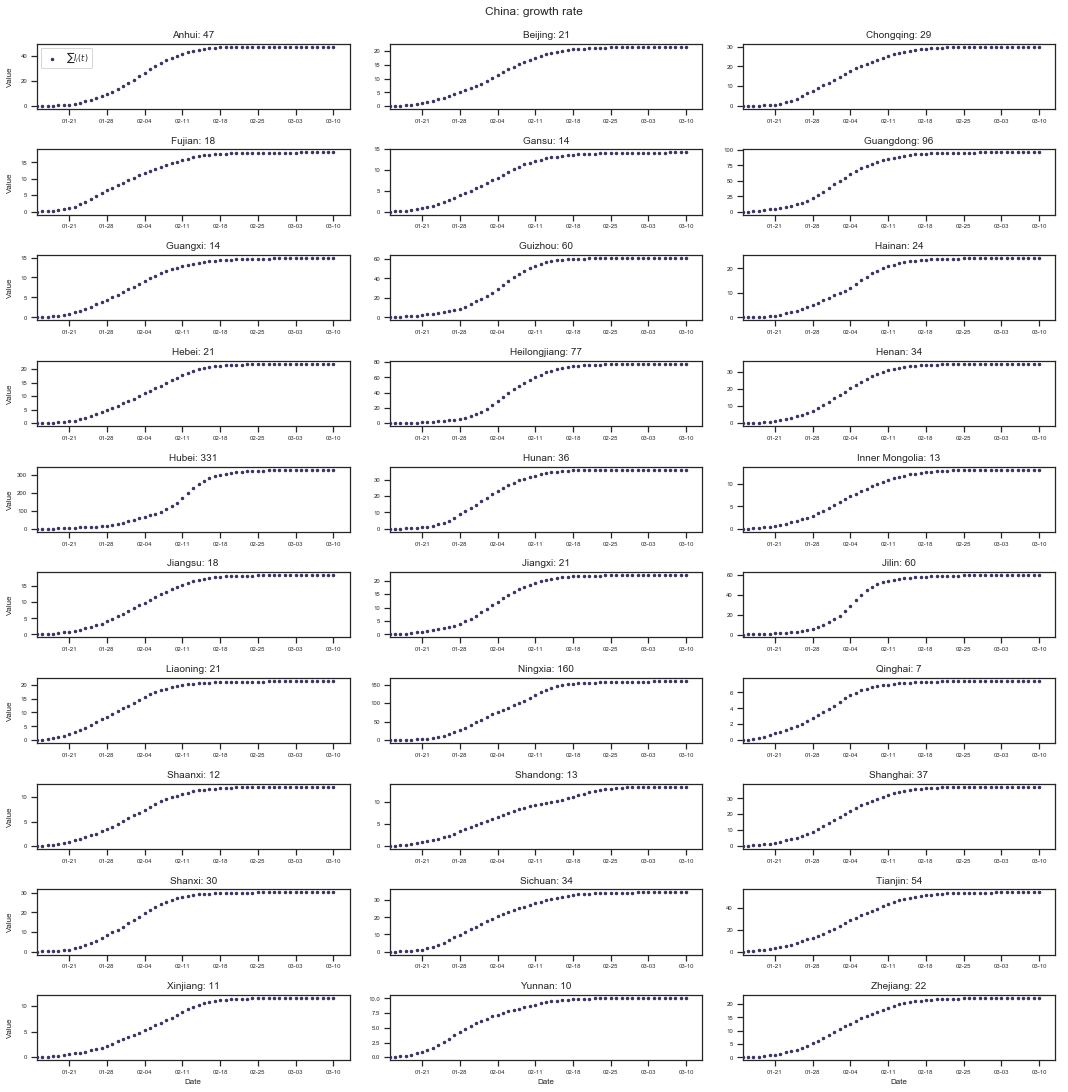

In [312]:
df_mparameters_all_o = figure_logistic(df = data_province_domestic, df_mparameters_all = df_mparameters_all, 
                                       update_date_tr = date_tr, mindex_list = mindex_list_real, fitting = False,
                                       fsize = (5, 1.5), ncol = 3, ms = 2, fs = 10, title = 'China', country = 'China')

* ## Exposed people
## $E(t)$

In [313]:
date_initial = min(data_province_domestic['update_date'])
est_S, est_E, est_I, est_R = ode_state(df = data_province_domestic, df_mparameters_state = df_mparameters_all, 
                                       update_date_tr = date_tr, mindex_list = mindex_list_real, T = 21, TT = 6, TI = 3, ti = 7, 
                                       sample = -1)

In [314]:
theta = 1e5
data_E_P2P = data_network_P2P.copy()
data_E_P2P = data_E_P2P[(data_E_P2P['update_date'] >= date_initial) & (data_E_P2P['update_date'] <= date_tr)].copy()
data_E_P2P = data_E_P2P.sort_values(by = ['update_date', 'source_en', 'target_en'])
data_E_P2P = data_E_P2P.reset_index(drop = True)
data_E_P2P['E_value'] = data_E_P2P.apply (lambda row: theta*row['value']/provincial_population_dict[row['source_en']]*est_E[(row['update_date'] - date_initial).days, names_province.index(row['source_en'])], axis = 1)

In [315]:
# from the ith province to the jth province: theta*m[i, j]/N[i]*E[i]

In [316]:
def figure_exposed_single(df_E_P2P, province, direction, ms, fsize, fs):
    
    df = df_E_P2P
    
    fig, ax = plt.subplots(figsize = fsize)
    sns.set_style('whitegrid')
    palette = tealrose
    palette_o = ['#d8b9c3', '#827397', '#4d4c7d', '#363062']
    
    a, b = 0.6, 0.6
    lw = 3
    if direction == 'move in':
        df_single = df_E_P2P[df_E_P2P['target_en'] == province].groupby(['update_date']).sum().copy()
        df_single.reset_index(level=0, inplace=True)
        
        # differenc response levels
        # before level 1 (include "= provincial_response_1_dict[province]")
        df_single_0 = df_single[df_single['update_date'] < provincial_response_1_dict[province]].copy()
        ax.plot(df_single_0['update_date'], df_single_0['E_value'], linewidth = lw, color = palette_o[1], alpha = a, label = None)
        ax.fill_between(df_single_0['update_date'], df_single_0['E_value'], 0, color = palette_o[1], alpha = a, label = 'no response')
        # level 1 (include "= provincial_response_3_dict[province]")
        if provincial_response_2_dict[province] == None: # without level 2
            df_single_1 = df_single[(df_single['update_date'] >= provincial_response_1_dict[province]) & (df_single['update_date'] < provincial_response_3_dict[province])].copy()
            ax.plot(df_single_1['update_date'], df_single_1['E_value'], linewidth = lw, color = tealrose[-2], alpha = a, label = None)
            axes[ix].fill_between(df_single_1['update_date'], df_single_1['E_value'], 0, color = tealrose[-2], alpha = a, label = 'class 1')
        else: # with level 2 (include "= provincial_response_2_dict[province]")
            df_single_1 = df_single[(df_single['update_date'] >= provincial_response_1_dict[province]) & (df_single['update_date'] < provincial_response_2_dict[province])].copy()
            df_single_2 = df_single[(df_single['update_date'] >= provincial_response_2_dict[province]) & (df_single['update_date'] < provincial_response_3_dict[province])].copy()
            ax.plot(df_single_1['update_date'], df_single_1['E_value'], linewidth = lw, color = tealrose[-2], alpha = a, label = None)
            ax.fill_between(df_single_1['update_date'], df_single_1['E_value'], 0, color = tealrose[-2], alpha = a, label = 'class 1')
            ax.plot(df_single_2['update_date'], df_single_2['E_value'], linewidth = lw, color = tealrose[3], alpha = a, label = None)
            ax.fill_between(df_single_2['update_date'], df_single_2['E_value'], 0, color = tealrose[3], alpha = a, label = 'class 2')
        # level 3
        df_single_3 = df_single[df_single['update_date'] >= provincial_response_3_dict[province]].copy()
        ax.plot(df_single_3['update_date'], df_single_3['E_value'], linewidth = lw, color = tealrose[1], alpha = a, label = None)
        ax.fill_between(df_single_3['update_date'], df_single_3['E_value'], 0, color = tealrose[1], alpha = a, label = 'class 3')
        
        
    elif direction == 'move out':
        df_single = df_E_P2P[df_E_P2P['source_en'] == province].groupby(['update_date']).sum().copy()
        df_single.reset_index(level=0, inplace=True)
        
        # differenc response levels
        # before level 1 (include "= provincial_response_1_dict[province]")
        df_single_0 = df_single[df_single['update_date'] < provincial_response_1_dict[province]].copy()
        ax.plot(df_single_0['update_date'], df_single_0['E_value'], linewidth = lw, color = palette_o[1], alpha = b, label = None)
        ax.fill_between(df_single_0['update_date'], df_single_0['E_value'], 0, color = palette_o[1], hatch = '+', alpha = b, label = 'no response')
        # level 1 (include "= provincial_response_3_dict[province]")
        if provincial_response_2_dict[province] == None: # without level 2
            df_single_1 = df_single[(df_single['update_date'] >= provincial_response_1_dict[province]) & (df_single['update_date'] < provincial_response_3_dict[province])].copy()
            ax.plot(df_single_1['update_date'], df_single_1['E_value'], linewidth = lw, color = tealrose[-2], alpha = b, label = None)
            axes[ix].fill_between(df_single_1['update_date'], df_single_1['E_value'], 0, color = tealrose[-2], hatch = '+', alpha = b, label = 'class 1')
        else: # with level 2 (include "= provincial_response_2_dict[province]")
            df_single_1 = df_single[(df_single['update_date'] >= provincial_response_1_dict[province]) & (df_single['update_date'] < provincial_response_2_dict[province])].copy()
            df_single_2 = df_single[(df_single['update_date'] >= provincial_response_2_dict[province]) & (df_single['update_date'] < provincial_response_3_dict[province])].copy()
            ax.plot(df_single_1['update_date'], df_single_1['E_value'], linewidth = lw, color = tealrose[-2], alpha = b, label = None)
            ax.fill_between(df_single_1['update_date'], df_single_1['E_value'], 0, color = tealrose[-2], hatch = '+', alpha = b, label = 'class 1')
            ax.plot(df_single_2['update_date'], df_single_2['E_value'], linewidth = lw, color = tealrose[3], alpha = b, label = None)
            ax.fill_between(df_single_2['update_date'], df_single_2['E_value'], 0, color = tealrose[3], hatch = '+', alpha = b, label = 'class 2')
        # level 3
        df_single_3 = df_single[df_single['update_date'] >= provincial_response_3_dict[province]].copy()
        ax.plot(df_single_3['update_date'], df_single_3['E_value'], linewidth = lw, color = tealrose[1], alpha = b, label = None)
        ax.fill_between(df_single_3['update_date'], df_single_3['E_value'], 0, color = tealrose[1], hatch = '+', alpha = b, label = 'class 3')
        
    
    else:
        
        df_single_in = df_E_P2P[df_E_P2P['target_en'] == province].groupby(['update_date']).sum().copy()
        df_single_in.reset_index(level=0, inplace=True)
        
        # differenc response levels
        # before level 1 (include "= provincial_response_1_dict[province]")
        df_single_0 = df_single_in[df_single_in['update_date'] < provincial_response_1_dict[province]].copy()
        ax.plot(df_single_0['update_date'], df_single_0['E_value'], linewidth = lw, color = palette_o[1], alpha = a, label = None)
        ax.fill_between(df_single_0['update_date'], df_single_0['E_value'], 0, color = palette_o[1], alpha = a, label = 'no response')
        
        # level 1 (include "= provincial_response_3_dict[province]")
        if provincial_response_2_dict[province] == None: # without level 2
            df_single_1 = df_single_in[(df_single_in['update_date'] >= provincial_response_1_dict[province]) & (df_single_in['update_date'] < provincial_response_3_dict[province])].copy()
            ax.plot(df_single_1['update_date'], df_single_1['E_value'], linewidth = lw, color = tealrose[-2], alpha = a, label = None)
            axes[ix].fill_between(df_single_1['update_date'], df_single_1['E_value'], 0, color = tealrose[-2], alpha = a, label = 'class 1')
        else: # with level 2 (include "= provincial_response_2_dict[province]")
            df_single_1 = df_single_in[(df_single_in['update_date'] >= provincial_response_1_dict[province]) & (df_single_in['update_date'] < provincial_response_2_dict[province])].copy()
            df_single_2 = df_single_in[(df_single_in['update_date'] >= provincial_response_2_dict[province]) & (df_single_in['update_date'] < provincial_response_3_dict[province])].copy()
            ax.plot(df_single_1['update_date'], df_single_1['E_value'], linewidth = lw, color = tealrose[-2], alpha = a, label = None)
            ax.fill_between(df_single_1['update_date'], df_single_1['E_value'], 0, color = tealrose[-2], alpha = a, label = 'class 1')
            ax.plot(df_single_2['update_date'], df_single_2['E_value'], linewidth = lw, color = tealrose[3], alpha = a, label = None)
            ax.fill_between(df_single_2['update_date'], df_single_2['E_value'], 0, color = tealrose[3], alpha = a, label = 'class 2')
        # level 3
        df_single_3 = df_single_in[df_single_in['update_date'] >= provincial_response_3_dict[province]].copy()
        ax.plot(df_single_3['update_date'], df_single_3['E_value'], linewidth = lw, color = tealrose[1], alpha = a, label = None)
        ax.fill_between(df_single_3['update_date'], df_single_3['E_value'], 0, color = tealrose[1], alpha = a, label = 'class 3')
        
        df_single_out = df_E_P2P[df_E_P2P['source_en'] == province].groupby(['update_date']).sum().copy()
        df_single_out.reset_index(level=0, inplace=True)
        
        # differenc response levels
        # before level 1 (include "= provincial_response_1_dict[province]")
        df_single_0 = df_single_out[df_single_out['update_date'] < provincial_response_1_dict[province]].copy()
        ax.plot(df_single_0['update_date'], df_single_0['E_value'], linewidth = lw, color = palette_o[1], alpha = b, label = None)
        ax.fill_between(df_single_0['update_date'], df_single_0['E_value'], 0, color = palette_o[1], hatch = '+', alpha = b, label = 'no response')
        # level 1 (include "= provincial_response_3_dict[province]")
        if provincial_response_2_dict[province] == None: # without level 2
            df_single_1 = df_single_out[(df_single_out['update_date'] >= provincial_response_1_dict[province]) & (df_single_out['update_date'] < provincial_response_3_dict[province])].copy()
            ax.plot(df_single_1['update_date'], df_single_1['E_value'], linewidth = lw, color = tealrose[-2], alpha = b, label = None)
            axes[ix].fill_between(df_single_1['update_date'], df_single_1['E_value'], 0, color = tealrose[-2], hatch = '+', alpha = b, label = 'class 1')
        else: # with level 2 (include "= provincial_response_2_dict[province]")
            df_single_1 = df_single_out[(df_single_out['update_date'] >= provincial_response_1_dict[province]) & (df_single_out['update_date'] < provincial_response_2_dict[province])].copy()
            df_single_2 = df_single_out[(df_single_out['update_date'] >= provincial_response_2_dict[province]) & (df_single_out['update_date'] < provincial_response_3_dict[province])].copy()
            ax.plot(df_single_1['update_date'], df_single_1['E_value'], linewidth = lw, color = tealrose[-2], alpha = b, label = None)
            ax.fill_between(df_single_1['update_date'], df_single_1['E_value'], 0, color = tealrose[-2], hatch = '+', alpha = b, label = 'class 1')
            ax.plot(df_single_2['update_date'], df_single_2['E_value'], linewidth = lw, color = tealrose[3], alpha = b, label = None)
            ax.fill_between(df_single_2['update_date'], df_single_2['E_value'], 0, color = tealrose[3], hatch = '+', alpha = b, label = 'class 2')
        # level 3
        df_single_3 = df_single_out[df_single_out['update_date'] >= provincial_response_3_dict[province]].copy()
        ax.plot(df_single_3['update_date'], df_single_3['E_value'], linewidth = lw, color = tealrose[1], alpha = b, label = None)
        ax.fill_between(df_single_3['update_date'], df_single_3['E_value'], 0, color = tealrose[1], hatch = '+', alpha = b, label = 'class 3')
        
    
    ax.set_xlabel("Date", fontsize = fs - 2)
    ax.set_ylabel("Number", fontsize = fs - 2)
    dict_title = {'move out': 'to', 'move in': 'from', 'both': 'from and to'}
    ax.set_title(province + ': exposed people ' + dict_title[direction] + ' other provinces', fontsize = fs, y = 1.15)
    ax.set_xlim(df_E_P2P['update_date'].min(), df_E_P2P['update_date'].max())
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
    
    #hand, label = axes[ix].get_legend_handles_labels()
    patch_0 = mpatches.Patch(color = palette_o[1], label = 'no response')
    patch_1 = mpatches.Patch(color = palette[-2], label = 'Class 1')
    patch_2 = mpatches.Patch(color = palette[3], label = 'Class 2')
    patch_3 = mpatches.Patch(color = palette[1], label = 'Class 3')
    #axes[ix].legend(hand[4:], label[4:], loc='upper center', bbox_to_anchor=(0.5, 1.5), 
                    #ncol = 4, fancybox = True, fontsize = fs - 2)
    leg = ax.legend(handles=[patch_0, patch_1, patch_2, patch_3], loc='upper center', bbox_to_anchor=(0.5, 1.15), 
              ncol = 4, fancybox = True, fontsize = fs - 4)
    plt.gca().add_artist(leg)
    patch_in = mpatches.Patch(color = palette[-2], fill=False, label = 'move in')
    patch_out = mpatches.Patch(color = palette[-2], fill=False, hatch = '+', label = 'move out')
    leg_direction = ax.legend(handles=[patch_in, patch_out], loc='upper center', frameon = False, ncol = 2,  fontsize = fs - 4)
            
    fig.savefig(_Figure_PATH_ + 'figures_china/' + province + '_exposed.png', dpi = 400, bbox_inches='tight')   
    
    

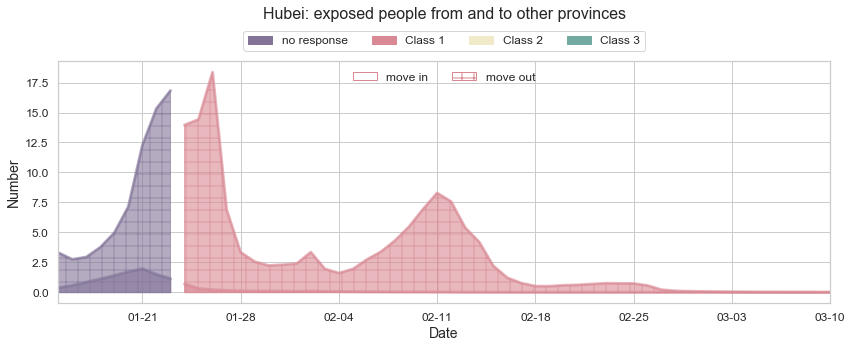

In [318]:
figure_exposed_single(data_E_P2P, 'Hubei', 'both', ms = 6, fsize = (12, 5), fs = 16)

In [319]:
def figure_exposed(df_E_P2P, ncol = 3, ms = 2, fsize = (5, 2), fs = 10, title = None, country = 'China'):
    
    m = len(names_province)
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (ncol*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.2, wspace = 0.1)
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
    
    palette = tealrose
    palette_o = ['#d8b9c3', '#827397', '#4d4c7d', '#363062']
    
    a, b = 0.6, 0.6
    lw = 2
    # direction: move_in
    for i, province in enumerate(names_province):
        
        ix = np.unravel_index(i, axes.shape)
        
        ######## move in ########
        df_single_in = df_E_P2P[df_E_P2P['target_en'] == province].groupby(['update_date']).sum().copy()
        df_single_in.reset_index(level = 0, inplace = True)
        
        # differenc response levels
        # before level 1 (include "= provincial_response_1_dict[province]")
        df_single_0 = df_single_in[df_single_in['update_date'] < provincial_response_1_dict[province]].copy()
        axes[ix].plot(df_single_0['update_date'], df_single_0['E_value'], linewidth = lw, color = palette_o[1], alpha = a, label = None)
        axes[ix].fill_between(df_single_0['update_date'], df_single_0['E_value'], 0, color = palette_o[1], alpha = a, label = 'no response')
        
        # level 1 
        if provincial_response_2_dict[province] == None: # without level 2 (include "= provincial_response_3_dict[province]")
            df_single_1 = df_single_in[(df_single_in['update_date'] >= provincial_response_1_dict[province]) & (df_single_in['update_date'] < provincial_response_3_dict[province])].copy()
            axes[ix].plot(df_single_1['update_date'], df_single_1['E_value'], linewidth = lw, color = tealrose[-2], alpha = a, label = None)
            axes[ix].fill_between(df_single_1['update_date'], df_single_1['E_value'], 0, color = tealrose[-2], alpha = a, label = 'class 1')
        else: # with level 2 (include "= provincial_response_2_dict[province]")
            df_single_1 = df_single_in[(df_single_in['update_date'] >= provincial_response_1_dict[province]) & (df_single_in['update_date'] < provincial_response_2_dict[province])].copy()
            df_single_2 = df_single_in[(df_single_in['update_date'] >= provincial_response_2_dict[province]) & (df_single_in['update_date'] < provincial_response_3_dict[province])].copy()
            axes[ix].plot(df_single_1['update_date'], df_single_1['E_value'], linewidth = lw, color = tealrose[-2], alpha = a, label = None)
            axes[ix].fill_between(df_single_1['update_date'], df_single_1['E_value'], 0, color = tealrose[-2], alpha = a, label = 'class 1')
            axes[ix].plot(df_single_2['update_date'], df_single_2['E_value'], linewidth = lw, color = tealrose[3], alpha = a, label = None)
            axes[ix].fill_between(df_single_2['update_date'], df_single_2['E_value'], 0, color = tealrose[3], alpha = a, label = 'class 2')
        # level 3
        df_single_3 = df_single_in[df_single_in['update_date'] >= provincial_response_3_dict[province]].copy()
        axes[ix].plot(df_single_3['update_date'], df_single_3['E_value'], linewidth = lw, color = tealrose[1], alpha = a, label = None)
        axes[ix].fill_between(df_single_3['update_date'], df_single_3['E_value'], 0, color = tealrose[1], alpha = a, label = 'class 3')
        
        ######## move out ########
        df_single_out = df_E_P2P[df_E_P2P['source_en'] == province].groupby(['update_date']).sum().copy()
        df_single_out.reset_index(level=0, inplace=True)
        
        # differenc response levels
        # before level 1 (include "= provincial_response_1_dict[province]")
        df_single_0 = df_single_out[df_single_out['update_date'] < provincial_response_1_dict[province]].copy()
        axes[ix].plot(df_single_0['update_date'], df_single_0['E_value'], linewidth = lw, color = palette_o[1], alpha = b, label = None)
        axes[ix].fill_between(df_single_0['update_date'], df_single_0['E_value'], 0, color = palette_o[1], hatch = '+', alpha = b, label = 'no response')
        # level 1
        if provincial_response_2_dict[province] == None: # without level 2 (include "= provincial_response_3_dict[province]")
            df_single_1 = df_single_out[(df_single_out['update_date'] >= provincial_response_1_dict[province]) & (df_single_out['update_date'] < provincial_response_3_dict[province])].copy()
            axes[ix].plot(df_single_1['update_date'], df_single_1['E_value'], linewidth = lw, color = tealrose[-2], alpha = b, label = None)
            axes[ix].fill_between(df_single_1['update_date'], df_single_1['E_value'], 0, color = tealrose[-2], hatch = '+', alpha = b, label = 'class 1')
        else: # with level 2 (include "= provincial_response_2_dict[province]")
            df_single_1 = df_single_out[(df_single_out['update_date'] >= provincial_response_1_dict[province]) & (df_single_out['update_date'] < provincial_response_2_dict[province])].copy()
            df_single_2 = df_single_out[(df_single_out['update_date'] >= provincial_response_2_dict[province]) & (df_single_out['update_date'] < provincial_response_3_dict[province])].copy()
            axes[ix].plot(df_single_1['update_date'], df_single_1['E_value'], linewidth = lw, color = tealrose[-2], alpha = b, label = None)
            axes[ix].fill_between(df_single_1['update_date'], df_single_1['E_value'], 0, color = tealrose[-2], hatch = '+', alpha = b, label = 'class 1')
            axes[ix].plot(df_single_2['update_date'], df_single_2['E_value'], linewidth = lw, color = tealrose[3], alpha = b, label = None)
            axes[ix].fill_between(df_single_2['update_date'], df_single_2['E_value'], 0, color = tealrose[3], hatch = '+', alpha = b, label = 'class 2')
        # level 3
        df_single_3 = df_single_out[df_single_out['update_date'] >= provincial_response_3_dict[province]].copy()
        axes[ix].plot(df_single_3['update_date'], df_single_3['E_value'], linewidth = lw, color = tealrose[1], alpha = b, label = None)
        axes[ix].fill_between(df_single_3['update_date'], df_single_3['E_value'], 0, color = tealrose[1], hatch = '+', alpha = b, label = 'class 3')
        
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            axes[ix].set_xlabel("Date", fontsize = fs - 2)
        if i % ncol == 0:
            axes[ix].set_ylabel("Number", fontsize = fs - 2)
        if i == 1:
            #hand, label = axes[ix].get_legend_handles_labels()
            patch_0 = mpatches.Patch(color = palette_o[1], label = 'no response')
            patch_1 = mpatches.Patch(color = palette[-2], label = 'Class 1')
            patch_2 = mpatches.Patch(color = palette[3], label = 'Class 2')
            patch_3 = mpatches.Patch(color = palette[1], label = 'Class 3')
            #axes[ix].legend(hand[4:], label[4:], loc='upper center', bbox_to_anchor=(0.5, 1.5), 
                            #ncol = 4, fancybox = True, fontsize = fs - 2)
            axes[ix].legend(handles=[patch_0, patch_1, patch_2, patch_3], loc='upper center', bbox_to_anchor=(0.5, 1.8), 
                            ncol = 4, fancybox = True, fontsize = fs - 2)
            
        if i == 0:
            patch_in = mpatches.Patch(color = palette[-2], fill=False, label = 'move in')
            patch_out = mpatches.Patch(color = palette[-2], fill=False, hatch = '+', label = 'move out')
            axes[ix].legend(handles=[patch_in, patch_out], loc='upper center', 
                            ncol = 2, fancybox = True, fontsize = fs - 2)
            
        axes[ix].tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        axes[ix].tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)  

        axes[ix].set_title(province, fontsize = fs)
        axes[ix].set_xlim(df_E_P2P['update_date'].min(), df_E_P2P['update_date'].max())
        axes[ix].xaxis.set_major_locator(mdates.WeekdayLocator())
        axes[ix].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

    fig.align_ylabels(axes[:, 0])    
    fig.suptitle('China: exposed people', fontsize = fs + 2, y = 1.015)
    
    fig.savefig(_Figure_PATH_ + 'figures_china/' + country + '_exposed.png', dpi = 400, bbox_inches='tight')      
        

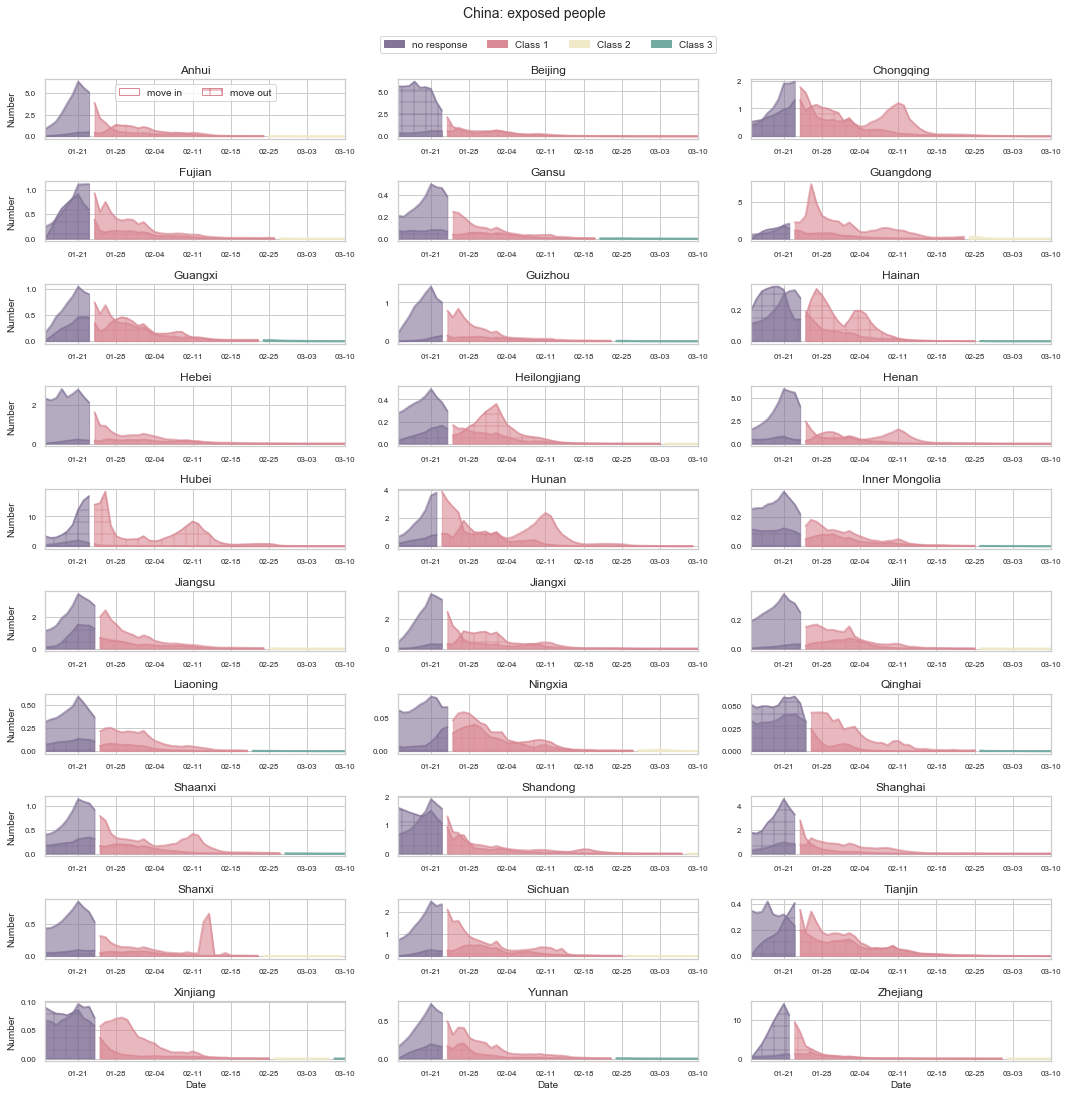

In [320]:
figure_exposed(data_E_P2P, ncol = 3, ms = 2, fsize = (5, 1.5), fs = 12, title = None, country = 'China')

In [323]:
def figure_exposed_bar(df_E_P2P, province, update_date_tr, largestN, log, fsize, fs, job):
    
    df = df_E_P2P[df_E_P2P['update_date'] <= update_date_tr].copy()
    
    if job == 'A':
        df = df[df['source_en'] == province].groupby(['target_en']).sum()
        
    elif job == 'B': 
        df = df.groupby(['source_en']).sum()
        
    df.reset_index(level = 0, inplace = True)
    df = df.sort_values(by = 'E_value')
    
    fig, ax = plt.subplots(figsize = fsize)
    sns.set_style('whitegrid')
    palette = tealrose

    if largestN > 0:
        df = df[-largestN:]  # only plot the first N bars
        palette = list(itertools.chain.from_iterable(itertools.repeat(x, int(np.ceil(largestN/len(palette)))) for x in palette))
        palette = palette[:largestN]
    else:
        largestN = df.shape[0]
        palette = list(itertools.chain.from_iterable(itertools.repeat(x, int(np.ceil(len(names_province)/len(palette)))) for x in palette))
        palette = palette[:len(names_province)]
        
    if job == 'A':
        names = df['target_en']
    elif job == 'B':
        names = df['source_en']
    bars = df['E_value'].tolist()
    
    
    ax.barh(names, bars, color = palette, height = 0.4, alpha = 0.8) # palette(np.linspace(0.2, 0.8, largestN))    
    for j, v in enumerate(bars): # add text
        ax.text(v + 0.02*max(bars), j - 0.2, str(int(round(v))), color = 'black', fontsize = fs - 6)
    ax.set_xlabel("Number of people", fontsize = fs - 2)
    ax.set_ylabel('Province', fontsize = fs - 2)
    if log == True:
        ax.set_xscale('log')
        xmin = np.power(10, np.floor(np.log10(min(bars))))
        xmax = np.power(10, np.ceil(np.log10(max(bars))))
        ax.set_xlim(xmin, xmax) 
    if job == 'A':
        ax.set_title('China' + ': exposed people from ' + province, fontsize = fs)
    elif job == 'B':
        ax.set_title('China' + ': exposed people from every province', fontsize = fs)
    

In [324]:
date_tr

datetime.date(2020, 3, 10)

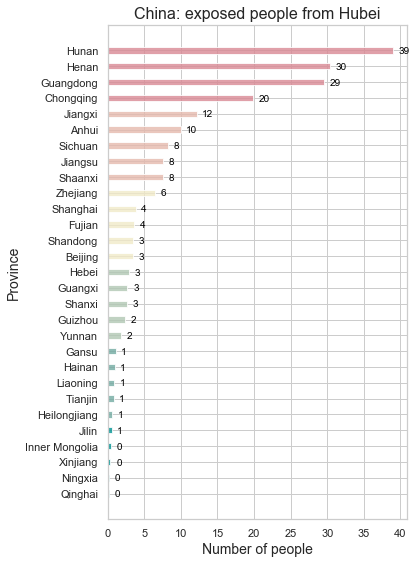

In [325]:
figure_exposed_bar(data_E_P2P, province = 'Hubei', update_date_tr = date_tr, 
                   largestN = False, log = False, fsize = (6, 8), fs = 16, job = 'A')

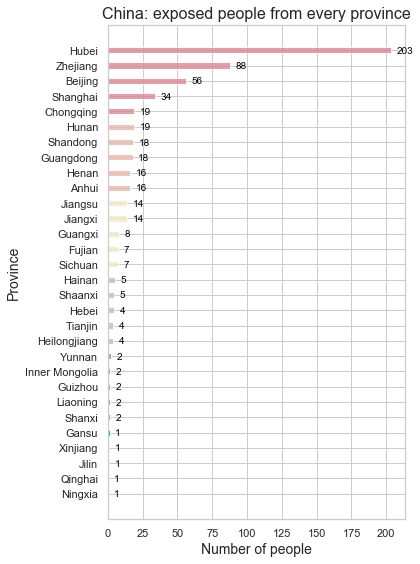

In [326]:
figure_exposed_bar(data_E_P2P, province = None, update_date_tr = date_tr, 
                   largestN = False, log = False, fsize = (6, 8), fs = 16, job = 'B')